In [1]:
### TODO
# * fit_models create_architectures_list (append mode)
# * fit_models worker if experiment id last digit in os environment var

# * collect garbage between fitting models

# * refactor custom_model_name and model_weights_path to instead use trained model id

# * delete cached sequences after each experiment

# train c3d and c3dsmall separately
# save model summary

In [2]:
# whether to log each feature and sequence status
verbose = True

In [3]:
# to get number of CPUs to parallelize fit generator batch loading
import multiprocessing

In [4]:
from contextlib import redirect_stdout

In [5]:
import gc
import os
import pandas as pd
import numpy as np
from PIL import Image
import json
import cv2
import matplotlib.pyplot as plt
import itertools
import sys
sys.path.append('..')

In [6]:
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D, Input
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D, Convolution1D, Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import img_to_array
import datetime

Using TensorFlow backend.


In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
# setup paths
pwd = os.getcwd().replace("deepvideoclassification","")
path_cache = pwd + 'cache/'
path_data = pwd + 'data/'

In [9]:
# setup logging
# any explicit log messages or uncaught errors to stdout and file /logs.log
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(pwd, "logs")),
        logging.StreamHandler()
    ])
# init logger
logger = logging.getLogger()
# make logger aware of any uncaught exceptions
def handle_exception(exc_type, exc_value, exc_traceback):
    if issubclass(exc_type, KeyboardInterrupt):
        sys.__excepthook__(exc_type, exc_value, exc_traceback)
        return

    logger.error("Uncaught exception", exc_info=(exc_type, exc_value, exc_traceback))
sys.excepthook = handle_exception

In [10]:
from deepvideoclassification.data import Data

In [11]:
# get worker id for this instance
WORKERID = None
try:
    WORKERID = int(os.environ['WORKERID'])
except:
    pass

logging.info("WORKER ID={}".format(WORKERID))

2019-01-20 08:20:50,516 [MainThread  ] [INFO ]  WORKER ID=1


# Pretrained_CNNs

In [12]:
# pretrained model shapes
pretrained_model_len_features = {}
#
pretrained_model_len_features['vgg16'] = 512
#

pretrained_model_len_features['mobilenetv2_1.00_224'] = 1280
#
pretrained_model_len_features['inception_resnet_v2'] = 1536
#
pretrained_model_len_features['resnet50'] = 2048
pretrained_model_len_features['xception'] = 2048
pretrained_model_len_features['inception_v3'] = 2048

In [13]:
# Notice the output features of the models group (roughly) into 3 buckets: 512, 1280 (with 1536), and 2048... 
# we'll do a grid search for 1 model in each bucket then run the best model in the grid for all other models in that bucket
pretrained_model_names_bucketed_subset = ['vgg16', 'inception_resnet_v2', 'resnet50']

In [14]:
# pretrained model shapes
pretrained_model_sizes = {}
#
pretrained_model_sizes['vgg16'] = (224,224)
pretrained_model_sizes['resnet50'] = (224,224)
pretrained_model_sizes['mobilenetv2_1.00_224'] = (224,224)
#
pretrained_model_sizes['xception'] = (299,299)
pretrained_model_sizes['inception_v3'] = (299,299)
pretrained_model_sizes['inception_resnet_v2'] = (299,299)

In [15]:
pretrained_model_names = ["inception_resnet_v2", "inception_v3", "mobilenetv2_1.00_224", "resnet50", "vgg16", "xception"]
poolings = ['max','avg']

In [16]:
def load_pretrained_model(pretrained_model_name, pooling, model_weights_path = None):
    """ Load pretrained model with given pooling applied
    
    Args:
        pretrained_model: name of pretrained model ["Xception", "VGG16", "ResNet50", "InceptionV3", "InceptionResNetV2", "MobileNetV2"]
        pooling: pooling strategy for final pretrained model layer ["max","avg"]
        :model_weights_path: path to custom model weights if we want to load CNN model we've fine-tuned to produce features (e.g. for LRCNN)
    
    Returns:
        Pretrained model object (excluding dense softmax 1000 ImageNet classes layer)
    """
    
    # initialize output
    model = None
    
    pretrained_model_name = pretrained_model_name.lower()
    
    ###########################
    ### import pretrained model
    ###########################
    if pretrained_model_name == "xception":   
        from keras.applications.xception import Xception
        model = Xception(include_top=False, weights='imagenet', pooling=pooling)
    elif pretrained_model_name == "vgg16":   
        from keras.applications.vgg16 import VGG16
        model = VGG16(include_top=False, weights='imagenet', pooling=pooling)
    elif pretrained_model_name == "resnet50":   
        from keras.applications.resnet50 import ResNet50
        model = ResNet50(include_top=False, weights='imagenet', pooling=pooling)
    elif pretrained_model_name == "inception_v3":   
        from keras.applications.inception_v3 import InceptionV3
        model = InceptionV3(include_top=False, weights='imagenet', pooling=pooling)
    elif pretrained_model_name == "inception_resnet_v2":   
        from keras.applications.inception_resnet_v2 import InceptionResNetV2
        model = InceptionResNetV2(include_top=False, weights='imagenet', pooling=pooling)
    elif pretrained_model_name == "mobilenetv2_1.00_224":   
        from keras.applications.mobilenet_v2 import MobileNetV2
        model = MobileNetV2(include_top=False, weights='imagenet', pooling=pooling)
    else:
        raise NameError('Invalid pretrained model name - must be one of ["Xception", "VGG16", "ResNet50", "InceptionV3", "InceptionResNetV2", "MobileNetV2"]')
    
    if model_weights_path is not None:
        if os.path.exists(model_weights_path):
            model.load_weights(model_weights_path)
        else:
            raise NameError('pretrained model weights not found')
    
    return model

In [17]:
def load_pretrained_model_preprocessor(pretrained_model_name):
    """
    Return preprocessing function for a given pretrained model
    """

    preprocess_input = None

    pretrained_model_name = pretrained_model_name.lower()
        
    if pretrained_model_name == "xception":   
        from keras.applications.xception import preprocess_input
    elif pretrained_model_name == "vgg16":   
        from keras.applications.vgg16 import preprocess_input
    elif pretrained_model_name == "resnet50":   
        from keras.applications.resnet50 import preprocess_input
    elif pretrained_model_name == "inception_v3":   
        from keras.applications.inception_v3 import preprocess_input
    elif pretrained_model_name == "inception_resnet_v2":   
        from keras.applications.inception_resnet_v2 import preprocess_input
    elif pretrained_model_name == "mobilenetv2_1.00_224":   
        from keras.applications.mobilenet_v2 import preprocess_input
    else:
        raise NameError('Invalid pretrained model name - must be one of ["Xception", "VGG16", "ResNet50", "InceptionV3", "InceptionResNetV2", "MobileNetV2"]')
        
    return preprocess_input

In [18]:
def precompute_CNN_features(pretrained_model_name, pooling, model_weights_path = None, custom_model_name = None):
    """ 
    Save pretrained features array computed over all frames of each video 
    using given pretrained model and pooling method
    
    :pretrained_model_name: pretrained model object loaded using `load_pretrained_model`
    :pooling: pooling method used with pretrained model
    :model_weights_path: path to custom model weights if we want to load CNN model we've fine-tuned to produce features (e.g. for LRCNN)
    :custom_model_name: custom output name to append to pretrained model name

    """
    
    assert (pretrained_model_name is not None or custom_model_name is not None), "need to specify a pretrained_model_name in ['Xception', 'VGG16', 'ResNet50', 'InceptionV3', 'InceptionResNetV2', 'MobileNetV2'] or a custom_model_name"
    
    pretrained_model_name = pretrained_model_name.lower()
    
    # setup path to save features
    path_features = path_cache + 'features/' + pretrained_model_name + "/" + pooling + '/'
    
    # store in custom directory if custom model name given (for when loading weights from fine-tuned CNN and precomputing features from that model)
    if custom_model_name is not None and model_weights_path is not None:
        path_features = path_cache + 'features/' + pretrained_model_name + "__" + custom_model_name + "/" + pooling + '/'
    
    if not os.path.exists(path_features):
        
        os.makedirs(path_features)
        
        # load pretrained model
        pretrained_model = load_pretrained_model(pretrained_model_name, pooling, model_weights_path)

        # load preprocessing function
        preprocess_input = load_pretrained_model_preprocessor(pretrained_model_name)

        # lookup pretrained model input shape
        model_input_size = pretrained_model_sizes[pretrained_model_name]
        
        # precompute features for each video using pretrained model
        from deepvideoclassification.data import get_video_paths
        path_videos = get_video_paths()

        for c, path_video in enumerate(path_videos):

            if verbose:
                logging.info("Computing pretrained model features for video {}/{} using pretrained model: {}, pooling: {}".format(c+1,len(path_videos),pretrained_model_name, pooling))

            # get video name from video path
            video_name = path_video.split("/")[-2]

            # build output path
            path_output = path_features + video_name

            try:
                if not os.path.exists(path_output + '.npy'):

                    path_frames = path_data + video_name + "/"

                    # initialize features list
                    features = []

                    frame_paths = os.listdir(path_frames)
                    frame_paths = [path_frames + f for f in frame_paths if f != '.DS_Store']

                    # sort paths in sequence (they were created with incrementing filenames through time)
                    frame_paths.sort()

                    # load each frame in vid and get features
                    for j, frame_path in enumerate(frame_paths):

                        # load image & preprocess
                        image = cv2.imread(frame_path, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(image, model_input_size, interpolation=cv2.INTER_AREA)
                        img = img_to_array(img)
                        img = np.expand_dims(img, axis=0)
                        img = preprocess_input(img)

                        # get features from pretrained model
                        feature = pretrained_model.predict(img).ravel()
                        features.append(feature)

                    # convert to arrays
                    features = np.array(features)

                    np.save(path_output, features)
                else:
                    if verbose:
                        logger.info("Features already cached: {}".format(path_output))

            except Exception as e:
                logging.error("Error precomputing features {} / {},{}".format(video_namepretrained_model_name, pooling))
                logging.fatal(e, exc_info=True)
                
    else:
        if verbose:
            logger.info("Features already cached: {}".format(path_features))

# Confusion Matrix

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Architecture class (contains keras model object and train/evaluate method, writes training results to /models/)

In [20]:
class Architecture(object):
    
    def __init__(self, model_id, architecture, sequence_length, 
                frame_size = None, 
                pretrained_model_name = None, pooling = None,
                sequence_model = None, sequence_model_layers = None,
                layer_1_size = 0, layer_2_size = 0, layer_3_size = 0, 
                dropout = 0, convolution_kernel_size = 3, 
                model_weights_path = None, 
                batch_size = 32, 
                verbose = False):
        """
        Model object constructor. Contains Keras model object and training/evaluation methods. Writes model results to /models/_id_ folder
        
        Architecture can be one of: 
        image_MLP_frozen, image_MLP_trainable, video_MLP_concat, video_LRCNN_frozen, video_LRCNN_trainable, C3D, C3Dsmall
        
        :model_id: integer identifier for this model e.g. 1337
        
        :architecture: architecture of model in [image_MLP_frozen, image_MLP_trainable, video_MLP_concat, video_LRCNN_frozen, video_LRCNN_trainable, C3D, C3Dsmall]
        
        :sequence_length: number of frames in sequence to be returned by Data object
        
        :frame_size: size that frames are resized to (different models / architectures accept different input sizes - will be inferred if pretrained_model_name is given since they have fixed sizes)
        :pretrained_model_name: name of pretrained model (or None if not using pretrained model e.g. for 3D-CNN)
        :pooling: name of pooling variant (or None if not using pretrained model e.g. for 3D-CNN or if fitting more non-dense layers on top of pretrained model base)
        
        :sequence_model: sequence model in [LSTM, SimpleRNN, GRU, Convolution1D]
        :sequence_model_layers: default to 1, can be stacked 2 or 3 (but less than 4) layer sequence model (assume always stacking the same sequence model, not mixing LSTM and GRU, for example)
        
        :layer_1_size: number of neurons in layer 1
        :layer_2_size: number of neurons in layer 2
        :layer_3_size: number of neurons in layer 3 
        
        :dropout: amount of dropout to add (same applied throughout model - good default is 0.2) 
        
        :convolution_kernel_size: size of 1-D convolutional kernel for 1-d conv sequence models (good default is 3)
        
        :model_weights_path: path to .h5 weights file to be loaded for pretrained CNN in LRCNN-trainable 
        
        :batch_size: batch size used to fit model (default to 32)
        
        :verbose: whether to log progress updates
        """
    
        # required params
        self.model_id = model_id
        
        # create path based on model id
        self.path_model = pwd + 'models/' + str(model_id) + '/'
        if not os.path.exists(self.path_model):
            os.makedirs(self.path_model)
        else:
            if not os.path.exists(self.path_model + 'results.json'):
                logging.info("Model folder exists but no results found - potential error in previous model training")
        
        self.architecture = architecture
        self.sequence_length = sequence_length
        
        # model architecture params
        self.frame_size = frame_size
        self.pretrained_model_name = pretrained_model_name
        self.pooling = pooling
        self.sequence_model = sequence_model
        self.sequence_model_layers = sequence_model_layers
        #
        self.layer_1_size = layer_1_size
        self.layer_2_size = layer_2_size
        self.layer_3_size = layer_3_size
        #
        self.dropout = dropout
        #
        self.convolution_kernel_size = convolution_kernel_size
        #
        self.model_weights_path = model_weights_path
        #
        self.batch_size = batch_size
        #
        self.verbose = verbose
        
        # fix case sensitivity
        if type(self.architecture) == str:
            self.architecture = self.architecture.lower()
        if type(self.pretrained_model_name) == str:
            self.pretrained_model_name = self.pretrained_model_name.lower()
        if type(self.pooling) == str:
            self.pooling = self.pooling.lower()
        
        # read num features from pretrained model
        if pretrained_model_name is not None:
            self.num_features = pretrained_model_len_features[pretrained_model_name]
            self.frame_size = pretrained_model_sizes[pretrained_model_name]
        
        # check one of pretrained model and frame size is specified
        assert (self.pretrained_model_name is not None or self.frame_size is not None), "Must specify one of pretrained_model_name or frame_size"
            
            
        # init model and data objects for this architecture
        self.model = None
        self.data = None
        
        
        #############################################################
        ### Build model architecture and init appropriate data object
        #############################################################
        
        if architecture == "image_MLP_frozen":
            
            ####################
            ### image_MLP_frozen
            ####################
            # image classification (single frame)
            # train MLP on top of weights extracted from pretrained CNN with no fine-tuning
            
            # check inputs
            assert self.sequence_length == 1, "image_MLP_frozen requires sequence length of 1"
            assert self.pretrained_model_name is not None, "image_MLP_frozen requires a pretrained_model_name input" 
            assert self.pooling is not None, "image_MLP_frozen requires a pooling input" 
            
            
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = 1, 
                                return_CNN_features = True, 
                                pretrained_model_name= self.pretrained_model_name,
                                pooling = self.pooling)
            
            # init model
            model = Sequential()

            # 1st layer group
            if self.layer_1_size > 0:
                model.add(Dense(self.layer_1_size, activation='relu', input_shape=(self.num_features,)))
                if self.dropout > 0:
                    model.add(Dropout(self.dropout))
                
            # 2nd layer group
            if self.layer_2_size > 0 and self.layer_1_size > 0:
                model.add(Dense(self.layer_2_size, activation='relu'))
                if self.dropout > 0:
                    model.add(Dropout(self.dropout))

            # 3rd layer group
            if self.layer_3_size > 0 and self.layer_2_size > 0 and self.layer_1_size > 0:
                model.add(Dense(self.layer_3_size, activation='relu'))
                if dropout > 0:
                    model.add(Dropout(self.dropout))

            # classifier layer
            model.add(Dense(self.data.num_classes, activation='softmax'))
            

        elif architecture == "image_MLP_trainable":
            
            #######################
            ### image_MLP_trainable
            #######################
            # image classification (single frame)
            # fine-tune pretrained CNN with MLP on top
            #
            # start off freezing base CNN layers then will unfreeze 
            # after each training round
            #
            # we will ultimately want to compare our best fine-tuned 
            # CNN as a feature extractor vs fixed ImageNet pretrained CNN features
            
            # check inputs
            assert self.sequence_length == 1, "image_MLP_trainable requires sequence length of 1"
            assert self.pretrained_model_name is not None, "image_MLP_trainable requires a pretrained_model_name input" 
            assert self.pooling is not None, "image_MLP_trainable requires a pooling input" 
            
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = 1, 
                                return_CNN_features = False, 
                                pretrained_model_name = self.pretrained_model_name,
                                pooling = self.pooling,
                                return_generator = True,
                                batch_size = self.batch_size)
            
            # create the base pre-trained model
            model_base = load_pretrained_model(self.pretrained_model_name, pooling=self.pooling)
            

            # freeze base model layers (will unfreeze after train top)
            for l in model_base.layers:
                l.trainable=False

            # use Keras functional API
            model_top = model_base.output

            # note layer names are there so we can exclude those layers 
            # when setting base model layers to trainable

            # 1st layer group
            if self.layer_1_size > 0:
                model_top = Dense(self.layer_1_size, activation="relu", name='top_a')(model_top)
                if self.dropout > 0:
                    model_top = Dropout(self.dropout, name='top_b')(model_top)

            # 2nd layer group
            if self.layer_2_size > 0 and self.layer_1_size > 0:
                model_top = Dense(self.layer_2_size, activation="relu", name='top_c')(model_top)
                if self.dropout > 0:
                    model_top = Dropout(self.dropout, name='top_d')(model_top)

            # 3rd layer group
            if self.layer_3_size > 0 and self.layer_2_size > 0 and self.layer_1_size > 0:
                model_top = Dense(self.layer_3_size, activation="relu", name='top_e')(model_top)
                if self.dropout > 0:
                    model_top = Dropout(self.dropout, name='top_f')(model_top)

            # classifier layer
            model_predictions = Dense(self.data.num_classes, activation="softmax", name='top_g')(model_top)

            # combine base and top models into single model object
            model = Model(inputs=model_base.input, outputs=model_predictions)
                
        elif architecture == "video_MLP_concat":

            ####################
            ### video_MLP_concat
            ####################
            
            # concatenate all frames in sequence and train MLP on top of concatenated frame input
            
            assert self.sequence_length > 1, "video_MLP_concat requires sequence length > 1"
            assert self.pretrained_model_name is not None, "video_MLP_concat requires a pretrained_model_name input"
            assert self.pooling is not None, "video_MLP_concat requires a pooling input"
            
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = self.sequence_length, 
                                return_CNN_features = True, 
                                pretrained_model_name=self.pretrained_model_name,
                                pooling = self.pooling)

            # init model
            model = Sequential()

            model.add(Flatten(input_shape=(self.sequence_length, self.num_features)))

            # 1st layer group
            if self.layer_1_size > 0:
                model.add(Dense(self.layer_1_size, activation='relu', input_shape=(self.num_features,)))
                if self.dropout > 0:
                    model.add(Dropout(self.dropout))

            # 2nd layer group
            if self.layer_2_size > 0 and self.layer_1_size > 0:
                model.add(Dense(self.layer_2_size, activation='relu'))
                if self.dropout > 0:
                    model.add(Dropout(self.dropout))

            # 3rd layer group
            if self.layer_3_size > 0 and self.layer_2_size > 0 and self.layer_1_size > 0:
                model.add(Dense(self.layer_3_size, activation='relu'))
                if self.dropout > 0:
                    model.add(Dropout(self.dropout))

            # classifier layer
            model.add(Dense(self.data.num_classes, activation='softmax'))
            
        elif architecture == "video_LRCNN_frozen":

            ######################
            ### video_LRCNN_frozen
            ######################
            
            # Implement:
            # “Long-Term Recurrent Convolutional Networks for Visual Recognition and Description.”
            # Donahue, Jeff, Lisa Anne Hendricks, Marcus Rohrbach, Subhashini Venugopalan, 
            # Sergio Guadarrama, Kate Saenko, and Trevor Darrell.  
            # Proceedings of the IEEE Computer Society Conference on Computer Vision and 
            # Pattern Recognition, 2015, 2625–34.
            #
            # Essentially they extract features with fine-tuned CNN then fit recurrent models on top
            # in the paper they only use LSTM but we will also try RNN, GRU and 1-D CNN
            # 
            # note: no fine-tuning of CNN in this frozen LRCNN architecture
            # 
            # implementation inspired by:
            # https://github.com/sagarvegad/Video-Classification-CNN-and-LSTM-/blob/master/train_CNN_RNN.py

            
            # check inputs
            assert self.sequence_length > 1, "video_LRCNN_frozen requires sequence length > 1"
            assert self.layer_1_size > 0, "video_LRCNN_frozen requires a layer_1_size > 0" 
            assert self.pretrained_model_name is not None, "video_LRCNN_frozen requires a pretrained_model_name input" 
            assert self.pooling is not None, "video_LRCNN_frozen requires a pooling input" 
            assert self.sequence_model_layers is not None, "video_LRCNN_frozen requires sequence_model_layers >= 1" 
            assert self.sequence_model_layers >= 1, "video_LRCNN_frozen requires sequence_model_layers >= 1" 
            assert self.sequence_model_layers < 4, "video_LRCNN_frozen requires sequence_model_layers <= 3" 
            assert self.sequence_model is not None, "video_LRCNN_frozen requires a sequence_model" 
            if self.sequence_model == 'Convolution1D':
                assert self.convolution_kernel_size > 0, "Convolution1D sequence model requires convolution_kernel_size parameter > 0"
                assert self.convolution_kernel_size < self.sequence_length, "convolution_kernel_size must be less than sequence_length"

                
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = self.sequence_length, 
                                return_CNN_features = True, 
                                pretrained_model_name = self.pretrained_model_name,
                                pooling = self.pooling)
            
                
            # set whether to return sequences for stacked sequence models
            return_sequences_1, return_sequences_2 = False, False
            if sequence_model_layers > 1 and layer_2_size > 0:
                return_sequences_1 = True
            if sequence_model_layers >= 2 and layer_3_size > 0 and layer_2_size > 0:
                return_sequences_2 = True
            
            # init model
            model = Sequential()

            # layer 1 (sequence layer)
            if sequence_model == "LSTM":
                model.add(LSTM(self.layer_1_size, return_sequences=return_sequences_1, dropout=self.dropout, 
                               input_shape=(self.sequence_length, self.num_features)))
            elif sequence_model == "SimpleRNN":
                model.add(SimpleRNN(self.layer_1_size, return_sequences=return_sequences_1, dropout=self.dropout, 
                               input_shape=(self.sequence_length, self.num_features)))
            elif sequence_model == "GRU":
                model.add(GRU(self.layer_1_size, return_sequences=return_sequences_1, dropout=self.dropout, 
                               input_shape=(self.sequence_length, self.num_features)))
            elif sequence_model == "Convolution1D":
                model.add(Convolution1D(self.layer_1_size, kernel_size = self.convolution_kernel_size, padding = 'valid', 
                               input_shape=(self.sequence_length, self.num_features)))
                if layer_2_size == 0 or sequence_model_layers == 1:
                    model.add(Flatten())
            else:
                raise NameError('Invalid sequence_model - must be one of [LSTM, SimpleRNN, GRU, Convolution1D]')    

            # layer 2 (sequential or dense)
            if layer_2_size > 0:
                if return_sequences_1 == False:
                    model.add(Dense(self.layer_2_size, activation='relu'))
                    model.add(Dropout(self.dropout))
                else:
                    if sequence_model == "LSTM":
                        model.add(LSTM(self.layer_2_size, return_sequences=return_sequences_2, dropout=self.dropout))
                    elif sequence_model == "SimpleRNN":
                        model.add(SimpleRNN(self.layer_2_size, return_sequences=return_sequences_2, dropout=self.dropout))
                    elif sequence_model == "GRU":
                        model.add(GRU(self.layer_2_size, return_sequences=return_sequences_2, dropout=self.dropout))
                    elif sequence_model == "Convolution1D":
                        model.add(Convolution1D(self.layer_2_size, kernel_size = self.convolution_kernel_size, padding = 'valid'))
                    else:
                        raise NameError('Invalid sequence_model - must be one of [LSTM, SimpleRNN, GRU, Convolution1D]') 

            # layer 3 (sequential or dense)
            if layer_3_size > 0:
                if sequence_model_layers < 3:
                    if sequence_model_layers == 2:
                        model.add(Flatten())
                    model.add(Dense(self.layer_3_size, activation='relu'))
                    model.add(Dropout(self.dropout))
                else:
                    if sequence_model == "LSTM":
                        model.add(LSTM(self.layer_3_size, return_sequences=False, dropout=self.dropout))
                        model.add(Flatten())
                    elif sequence_model == "SimpleRNN":
                        model.add(SimpleRNN(self.layer_3_size, return_sequences=False, dropout=self.dropout))
                        model.add(Flatten())
                    elif sequence_model == "GRU":
                        model.add(GRU(self.layer_3_size, return_sequences=False, dropout=self.dropout))
                        model.add(Flatten())
                    elif sequence_model == "Convolution1D":
                        model.add(Convolution1D(self.layer_3_size, kernel_size = self.convolution_kernel_size, padding = 'valid'))
                        model.add(Flatten())
                    else:
                        raise NameError('Invalid sequence_model - must be one of [LSTM, SimpleRNN, GRU, Convolution1D]') 
            else:
                if return_sequences_2 == True: 
                    model.add(Flatten())

            # classifier layer
            if self.dropout > 0:
                model.add(Dropout(self.dropout))
            model.add(Dense(self.data.num_classes, activation='softmax'))

        elif architecture == "video_LRCNN_trainable":
            
            #########################
            ### video_LRCNN_trainable
            #########################
            
            # Same as above:
            # “Long-Term Recurrent Convolutional Networks for Visual Recognition and Description.”
            # Donahue, Jeff, Lisa Anne Hendricks, Marcus Rohrbach, Subhashini Venugopalan, 
            # Sergio Guadarrama, Kate Saenko, and Trevor Darrell.  
            # Proceedings of the IEEE Computer Society Conference on Computer Vision and 
            # Pattern Recognition, 2015, 2625–34.
            #
            # But with fine-tuning of the CNNs that are input into the recurrent models
            # 
            # note: will take long because not precomputing the CNN part so re-computed 
            # on each training pass

            # implementation inspired by https://stackoverflow.com/questions/49535488/lstm-on-top-of-a-pre-trained-cnn
            
            # check inputs
            assert self.sequence_length > 1, "video_LRCNN_trainable requires sequence length > 1"
            assert self.layer_1_size > 0, "video_LRCNN_trainable requires a layer_1_size > 0" 
            assert self.pretrained_model_name is not None, "video_LRCNN_trainable requires a pretrained_model_name input" 
            assert self.pooling is not None, "video_LRCNN_trainable requires a pooling input" 
            assert self.sequence_model_layers >= 1, "video_LRCNN_trainable requires sequence_model_layers >= 1" 
            assert self.sequence_model_layers < 4, "video_LRCNN_trainable requires sequence_model_layers <= 3" 
            assert self.sequence_model is not None, "video_LRCNN_trainable requires a sequence_model" 
            if self.sequence_model == 'Convolution1D':
                assert self.convolution_kernel_size > 0, "Convolution1D sequence model requires convolution_kernel_size parameter > 0"
                assert self.convolution_kernel_size < self.sequence_length, "convolution_kernel_size must be less than sequence_length"
                
                
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = self.sequence_length, 
                                return_CNN_features = False, 
                                return_generator=True,
                                pretrained_model_name = self.pretrained_model_name,
                                pooling = self.pooling,
                                batch_size=self.batch_size)
            
                
            # set whether to return sequences for stacked sequence models
            return_sequences_1, return_sequences_2 = False, False
            if sequence_model_layers > 1 and layer_2_size > 0:
                return_sequences_1 = True
            if sequence_model_layers >= 2 and layer_3_size > 0 and layer_2_size > 0:
                return_sequences_2 = True

            # load pretrained model weights - will train from there
            model_cnn = load_pretrained_model(self.pretrained_model_name, pooling=self.pooling)

            # optionally load weights for pretrained architecture
            # (will likely be better to first train CNN then load weights in LRCNN vs. use pretrained ImageNet CNN)
            if self.model_weights_path is not None:
                model_base.load_weights(self.model_weights_path)
            
            # freeze model_cnn layers but make final 3 layers of pretrained CNN trainable
            for i, l in enumerate(model_cnn.layers):
                if i < len(model_cnn.layers)-3:
                    l.trainable = False
                else:
                    l.trainable = True

            # sequential component on top of CNN
            frames = Input(shape=(self.sequence_length, self.frame_size[0], self.frame_size[1], 3))
            x = TimeDistributed(model_cnn)(frames)
            x = TimeDistributed(Flatten())(x)
            

            # layer 1 (sequence layer)
            if sequence_model == "LSTM":
                x = LSTM(self.layer_1_size, return_sequences=return_sequences_1, dropout=self.dropout)(x)
            elif sequence_model == "SimpleRNN":
                x = SimpleRNN(self.layer_1_size, return_sequences=return_sequences_1, dropout=self.dropout)(x)
            elif sequence_model == "GRU":
                x = GRU(self.layer_1_size, return_sequences=return_sequences_1, dropout=self.dropout)(x)
            elif sequence_model == "Convolution1D":
                x = Convolution1D(self.layer_1_size, kernel_size = self.convolution_kernel_size, padding = 'valid')(x)
                if layer_2_size == 0 or sequence_model_layers == 1:
                    x = Flatten()(x)
            else:
                raise NameError('Invalid sequence_model - must be one of [LSTM, SimpleRNN, GRU, Convolution1D]')    

            # layer 2 (sequential or dense)
            if layer_2_size > 0:
                if return_sequences_1 == False:
                    x = Dense(self.layer_2_size, activation='relu')(x)
                    x = Dropout(self.dropout)(x)
                else:
                    if sequence_model == "LSTM":
                        x = LSTM(self.layer_2_size, return_sequences=return_sequences_2, dropout=self.dropout)(x)
                    elif sequence_model == "SimpleRNN":
                        x = SimpleRNN(self.layer_2_size, return_sequences=return_sequences_2, dropout=self.dropout)(x)
                    elif sequence_model == "GRU":
                        x = GRU(self.layer_2_size, return_sequences=return_sequences_2, dropout=self.dropout)(x)
                    elif sequence_model == "Convolution1D":
                        x = Convolution1D(self.layer_2_size, kernel_size = self.convolution_kernel_size, padding = 'valid')(x)
                    else:
                        raise NameError('Invalid sequence_model - must be one of [LSTM, SimpleRNN, GRU, Convolution1D]') 

            # layer 3 (sequential or dense)
            if layer_3_size > 0:
                if sequence_model_layers < 3:
                    if sequence_model_layers == 2:
                        x = Flatten()(x)
                    x = Dense(self.layer_3_size, activation='relu')(x)
                    x = Dropout(self.dropout)(x)
                else:
                    if sequence_model == "LSTM":
                        x = LSTM(self.layer_3_size, return_sequences=False, dropout=self.dropout)(x)
                        x = Flatten()(x)
                    elif sequence_model == "SimpleRNN":
                        x = SimpleRNN(self.layer_3_size, return_sequences=False, dropout=self.dropout)(x)
                        x = Flatten()(x)
                    elif sequence_model == "GRU":
                        x = GRU(self.layer_3_size, return_sequences=False, dropout=self.dropout)(x)
                        x = Flatten()(x)
                    elif sequence_model == "Convolution1D":
                        x = Convolution1D(self.layer_3_size, kernel_size = self.convolution_kernel_size, padding = 'valid')(x)
                        x = Flatten()(x)
                    else:
                        raise NameError('Invalid sequence_model - must be one of [LSTM, SimpleRNN, GRU, Convolution1D]') 
            else:
                if return_sequences_2 == True: 
                    x = Flatten()(x)

            # classifier layer
            if self.dropout > 0:
                x = Dropout(self.dropout)(x)
            out = Dense(self.data.num_classes, activation='softmax')(x)
                        

            # join cnn frame model and LSTM top
            model = Model(inputs=frames, outputs=out)
         
        elif architecture == "C3D":
            
            #########
            ### C3D
            #########
            
            # Implement:
            # Learning Spatiotemporal Features with 3D Convolutional Networks
            # Tran et al 2015
            # https://arxiv.org/abs/1412.0767
            #
            # Implementation inspired by https://gist.github.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2
            
            assert self.sequence_length == 16, "C3D requires sequence length 16"
            assert self.frame_size == (112,112), "C3D requires frame size 112x112"
            assert self.layer_1_size == 0, "C3D does not accept layer size inputs since it's a predefined architecture"
            assert self.layer_2_size == 0, "C3D does not accept layer size inputs since it's a predefined architecture"
            assert self.layer_3_size == 0, "C3D does not accept layer size inputs since it's a predefined architecture"
            assert self.dropout == 0, "C3D does not accept layer size inputs since it's a predefined architecture"
            assert self.sequence_model == None, "C3D does not accept a sequence_model parameter"
            assert self.sequence_model_layers == None, "C3D does not accept a sequence_model_layers parameter"
            assert self.pretrained_model_name == None, "C3D does not accept a pretrained_model_name parameter"            
            assert self.pooling == None, "C3D does not accept a pooling parameter"                            
            
            
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = 16, 
                                return_CNN_features = False, 
                                return_generator = True,
                                frame_size = (112,112),
                                batch_size=self.batch_size,
                                verbose = False)
            
            # C3D
            model = Sequential()
            # 1st layer group
            model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv1', input_shape=(16, 112, 112, 3)))
            model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))
            # 2nd layer group
            model.add(Conv3D(128, (3, 3, 3), activation='relu',padding='same', name='conv2'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),padding='valid', name='pool2'))
            # 3rd layer group
            model.add(Conv3D(256, (3, 3, 3), activation='relu',padding='same', name='conv3a'))
            model.add(Conv3D(256, (3, 3, 3), activation='relu',padding='same', name='conv3b'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))
            # 4th layer group
            model.add(Conv3D(512, (3, 3, 3), activation='relu',padding='same', name='conv4a'))
            model.add(Conv3D(512, (3, 3, 3), activation='relu',padding='same', name='conv4b'))
            model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),padding='valid', name='pool4'))
            # 5th layer group
            model.add(Conv3D(512, (3, 3, 3), activation='relu',padding='same', name='conv5a'))
            model.add(Conv3D(512, (3, 3, 3), activation='relu',padding='same', name='conv5b'))
            model.add(ZeroPadding3D(padding=(0, 1, 1)))
            model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),padding='valid', name='pool5'))
            model.add(Flatten())
            # FC layers group
            model.add(Dense(4096, activation='relu', name='fc6'))
            model.add(Dropout(.5))
            model.add(Dense(4096, activation='relu', name='fc7'))
            model.add(Dropout(.5))
            model.add(Dense(self.data.num_classes, activation='softmax', name='fc8'))
            
        elif architecture == "C3Dsmall":
            
            #########################
            ### C3D - small variation
            #########################
            
            # Custom small version of C3D from paper:
            # Learning Spatiotemporal Features with 3D Convolutional Networks
            # Tran et al 2015
            # https://arxiv.org/abs/1412.0767
            #
            # Implementation inspired by https://gist.github.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2
            
            assert self.sequence_length == 16, "C3Dsmall requires sequence length 16"
            assert self.frame_size == (112,112), "C3Dsmall requires frame size 112x112"
            assert self.layer_1_size == 0, "C3Dsmall does not accept layer size inputs since it's a predefined architecture"
            assert self.layer_2_size == 0, "C3Dsmall does not accept layer size inputs since it's a predefined architecture"
            assert self.layer_3_size == 0, "C3Dsmall does not accept layer size inputs since it's a predefined architecture"
            assert self.dropout == 0, "C3Dsmall does not accept layer size inputs since it's a predefined architecture"
            assert self.sequence_model == None, "C3Dsmall does not accept a sequence_model parameter"
            assert self.sequence_model_layers == None, "C3Dsmall does not accept a sequence_model_layers parameter"
            assert self.pretrained_model_name == None, "C3Dsmall does not accept a pretrained_model_name parameter"            
            assert self.pooling == None, "C3Dsmall does not accept a pooling parameter"      
            
            
            ### create data object for this architecture
            if self.verbose:
                logging.info("Loading data")
            self.data = Data(sequence_length = 16, 
                                return_CNN_features = False, 
                                return_generator = True,
                                frame_size = (112,112),
                                batch_size=self.batch_size,
                                verbose = False)
            
            # C3Dsmall
            model = Sequential()
            # 1st layer group
            model.add(Conv3D(32, (3,3,3), activation='relu', input_shape=(data.sequence_length, 112, 112, 3)))
            model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
            # 2nd layer group
            model.add(Conv3D(64, (3,3,3), activation='relu'))
            model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
            # 3rd layer group
            model.add(Conv3D(128, (3,3,3), activation='relu'))
            model.add(Conv3D(128, (3,3,3), activation='relu'))
            model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
            # 4th layer group
            model.add(Conv3D(256, (2,2,2), activation='relu'))
            model.add(Conv3D(256, (2,2,2), activation='relu'))
            model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
            # FC layers group
            model.add(Flatten())
            model.add(Dense(256))
            model.add(Dropout(0.5))
            model.add(Dense(128))
            model.add(Dropout(0.5))
            model.add(Dense(self.data.num_classes, activation='softmax'))
            
        else:
            raise NameError('Invalid architecture - must be one of [image_MLP_frozen, image_MLP_trainable, video_MLP_concat, video_LRCNN_frozen, video_LRCNN_trainable, C3D, C3Dsmall]')    
        
        
        
        
        ###############
        ### Finish init
        ###############
        
        # set class model to constructed model
        self.model = model
        
        # load weights of model if they exist
        if os.path.exists(self.path_model + 'model.h5'):
            if self.verbose:
                logging.info("Loading saved model weights")
            model.load_weights(self.path_model + 'model.h5')            
        
        # save model summary to model folder
        with open(self.path_model + 'model_summary.txt', 'w') as f:
            with redirect_stdout(f):
                self.model.summary()
        
        # save architecture params to model folder
        params = self.__dict__.copy()
        params['data_shape'] = str(self.data)
        del params['model']
        del params['data']
        with open(self.path_model + 'params.json', 'w') as fp:
            json.dump(params, fp, indent=4, sort_keys=True)
    
    
    def train_model(self):
        """
        Run several rounds of fitting to train model, reducing learning rate after each round
        
        Progress and model parameters will be saved to the model's path e.g. /models/1/
        
        """
        
        # init results with architecture params
        results = self.__dict__.copy()
        results['data_total_rows_train'] = self.data.total_rows_train
        results['data_total_rows_valid'] = self.data.total_rows_valid
        results['data_total_rows_test'] = self.data.total_rows_test
        del results['model']
        del results['data']
        results['model_param_count'] = self.model.count_params()
        
        
        ###############
        ### Train model
        ###############
        
        # start training timer
        start = datetime.datetime.now()
        results['fit_dt_train_start'] = start.strftime("%Y-%m-%d %H:%M:%S")
        
        # do first round of fitting
        history1, stopped_epoch1 = self.fit(learning_rate = 0.001)
        
        # load best model weights so far
        self.model.load_weights(self.path_model + 'model.h5')
        
        # reduce learning rate and fit some more
        history2, stopped_epoch2 = self.fit(learning_rate = 0.0001)
        
        # load best model weights so far
        self.model.load_weights(self.path_model + 'model.h5')
        
        # reduce learning rate and fit some more
        history3, stopped_epoch3 = self.fit(learning_rate = 0.00001)
        
        # end time training
        end = datetime.datetime.now()    
        results['fit_dt_train_end']  = end.strftime("%Y-%m-%d %H:%M:%S")
        results['fit_dt_train_duration_seconds']  = str((end - start).total_seconds()).split(".")[0]
        
        
        #################
        ### build results
        #################
        # combine fit histories into big dataframe and write to model folder
        # only keep history until accuracy declined (where early stopping made checkpoint)

        # parse history dicts to dataframes
        history1 = pd.DataFrame(history1.history).head(stopped_epoch1)
        history1['fit_round'] = 1
        history2 = pd.DataFrame(history2.history).head(stopped_epoch2)
        history2['fit_round'] = 2
        history3 = pd.DataFrame(history3.history).head(stopped_epoch3)
        history3['fit_round'] = 3
        
        # combine and save csv
        fit_history = pd.concat([history1, history2, history3], axis=0)
        fit_history = fit_history.reset_index(drop=True)
        fit_history['epoch'] = fit_history.index+1
        fit_history.to_csv(self.path_model + 'fit_history.csv')
        self.fit_history = fit_history
        
        results['fit_stopped_epoch1'] = stopped_epoch1
        results['fit_stopped_epoch2'] = stopped_epoch2
        results['fit_stopped_epoch3'] = stopped_epoch3
        
        # add 3 = 1 for each training round because stopped_epoch is 0 indexed
        results['fit_num_epochs'] = stopped_epoch1 + stopped_epoch2 + stopped_epoch3 + 3
        results['fit_val_acc'] = list(fit_history.tail(1)['val_acc'])[0]
        results['fit_train_acc'] = list(fit_history.tail(1)['acc'])[0]
        results['fit_val_loss'] = list(fit_history.tail(1)['val_loss'])[0]
        results['fit_train_loss'] = list(fit_history.tail(1)['loss'])[0]

        #######################
        ### Predict on test set
        #######################
        
        # start test timer
        start = datetime.datetime.now()
        results['fit_dt_test_start'] = start.strftime("%Y-%m-%d %H:%M:%S")
        
        y_pred = None
        y_test = None
        if self.data.return_generator:
            # predict on test set via generator
            y_pred = self.model.predict_generator(self.data.generator_test,verbose=self.verbose)
            
            # save predicted clas probabilities
            np.save(self.path_model + 'test_predictions', y_pred)
            
            # take argmax to get predicted class
            y_pred = np.argmax(y_pred, axis = 1)

            # get truth labels from generator
            y_test = []
            for _, label in self.data.generator_test:
                y_test.extend(label)
            y_test = np.argmax(np.array(y_test), axis = 1)
            
        else:
            # predict on test data loaded into memory
            y_pred = self.model.predict(self.data.x_test, verbose=self.verbose)
            
            # save predicted clas probabilities
            np.save(self.path_model + 'test_predictions', y_pred)
            
            # take argmax to get predicted class
            y_pred = np.argmax(y_pred, axis=1)

            # get truth labels from memory
            y_test = np.argmax(self.data.y_test,axis=1)
        
        # end time testing
        end = datetime.datetime.now()    
        results['fit_dt_test_end']  = end.strftime("%Y-%m-%d %H:%M:%S")
        results['fit_dt_test_duration_seconds']  = str((end - start).total_seconds()).split(".")[0]
        
        ############################
        ### Compute confusion matrix
        ############################
        
        # Compute and store confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        pd.DataFrame(cnf_matrix).to_csv(self.path_model + "confusion_matrix.csv")

        # get clas names from label map for plot
        class_names = list(self.data.label_map.values())

        # Plot non-normalized confusion matrix
        plt.figure(figsize=(8,8))
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
        plt.savefig(self.path_model + 'confusion_matrix.png', bbox_inches='tight')

        # Plot normalized confusion matrix
        plt.figure(figsize=(8,8))
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
        plt.savefig(self.path_model + 'confusion_matrix_normalized.png', bbox_inches='tight')
        
        
        ##########################
        ### Compute raw error rate
        ##########################
        
        # build dataframe and calculate test error (assuming we classify using majority rule, not ROC cutoff approach)
        pdf = pd.DataFrame(y_pred, columns = ['pred'])
        pdf['prediction'] = pdf['pred'].apply(lambda x: self.data.label_map[str(x)])

        truth = pd.DataFrame(y_test, columns = ['truth'])
        truth['label'] = truth['truth'].apply(lambda x: self.data.label_map[str(x)])
        truth = truth[['label']]

        pdf = pd.concat([pdf, truth], axis=1)
        pdf['error'] = (pdf['prediction'] != pdf['label']).astype(int)
        test_acc = 1 - pdf['error'].mean()
        
        results['fit_test_acc'] = test_acc
        
        if self.verbose:
            logger.info(str(results))
            logger.info("model {} test acc: {}".format(self.model_id, test_acc))
        
        
        ##################
        ### Output results
        ##################
        self.results = results
        with open(self.path_model + 'results.json', 'w') as fp:
            json.dump(results, fp, indent=4, sort_keys=True)

        
    def fit(self, learning_rate = 0.001, epochs = 30, patience=5):
        """
        Compile and fit model for *epochs* rounds of training, dividing learning rate by 10 after each round

        Fitting will stop if val_acc does not improve for at least patience epochs

        Only the best weights will be kept

        The model is saved to /models/*model_id*/

        Good practice is to decrease the learning rate by a factor of 10 after each plateau and train some more 
        (after first re-loading best weights from previous training round)...

        for example (not exact example because this fit method has been refactored into the architecture object but the principle remains):
            fit_history = fit(model_id, model, data, learning_rate = 0.001, epochs = 30)
            model.load_weights(path_model + "model.h5")
            model = fit(model, 5)
            fit_history = train(model_id, model, data, learning_rate = 0.0001, epochs = 30)

        :learning_rate: learning rate parameter for Adam optimizer (default is 0.001)

        :epochs: number of training epochs per fit round (subject to patience)
        :batch_size: number of samples in each batch
        :patience: how many epochs without val_acc improvement before stopping fit round
        :verbose: print progress

        """

        # get number of processors for multiprocessing fit generators
        num_workers = multiprocessing.cpu_count()

        # create optimizer with given learning rate 
        opt = Adam(lr = learning_rate)

        # compile model
        self.model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

        # setup training callbacks
        callback_stopper = EarlyStopping(monitor='val_acc', patience=patience, verbose=0)
        callback_csvlogger = CSVLogger(self.path_model + 'training.log')
        callback_checkpointer = ModelCheckpoint(self.path_model +  'model.h5', monitor='val_acc', save_best_only=True, verbose=verbose)
        callbacks = [callback_stopper, callback_checkpointer, callback_csvlogger]

        # fit model
        if self.data.return_generator == True:
            # train using generator
            history = self.model.fit_generator(generator=self.data.generator_train,
                validation_data=self.data.generator_valid,
                use_multiprocessing=True,
                workers=num_workers,
                epochs=epochs,
                callbacks=callbacks,
                shuffle=True,
                verbose=self.verbose)
        else:
            # train using full dataset
            history = self.model.fit(self.data.x_train, self.data.y_train, 
                validation_data=(self.data.x_valid, self.data.y_valid),
                batch_size=self.batch_size,
                epochs=epochs,
                callbacks=callbacks,
                shuffle=True,
                verbose=self.verbose)

        # get number of epochs actually trained (might have early stopped)
        epochs_trained = callback_stopper.stopped_epoch
        
        if epochs_trained == 0:
            # trained but didn't stop early
            if len(history.history) > 0:
                epochs_trained = epochs
        else:
            # subtract patience from stop point to get actual peak epoch for this fitting round
            epochs_trained -= patience 
        
        # return fit history and the epoch that the early stopper completed on
        return history, epochs_trained
        
        
    def make_last_layers_trainable(self, num_layers):
        """
        Set the last *num_layers* non-trainable layers to trainable  

        NB to be used with model_base and assumes name = "top_xxx" added to each top layer to know 
        to ignore that layer when looping through layers from top backwards

        :num_layers: number of layers from end of model (that are currently not trainable) to be set as trainable
        """

        # get index of last non-trainable layer
        # (the layers we added on top of model_base are already trainable=True)
        # ...
        # need to find last layer of base model and set that (and previous num_layers)
        # to trainable=True via this method

        # find last non-trainable layer index
        idx_not_trainable = 0
        for i, l in enumerate(self.model.layers):
            if "top" not in l.name:
                idx_not_trainable = i

        # set last non-trainable layer and num_layers prior to trainable=True
        for i in reversed(range(idx_not_trainable-num_layers+1, idx_not_trainable+1)):
            self.model.layers[i].trainable = True
        
        if self.verbose:
            logging.info("last {} layers of CNN set to trainable".format(num_layers))

# Create experiments lists and run experiments

* batch 1 = run frozen MLPs and LRCNNs and all concats

* batch 2 = run trainable MLP and LRCNN on best performing frozen variants

* batch 3 = run trainable but initializing with best CNN weights

* batch 4 = run C3D models

## Experiment batch 1

In [21]:
experiment_batch_name = 'experiment_batch_1'

In [90]:
# init list of experiments
experiments = []

In [91]:
pooling = 'max'
layer_sizes = [512, 256, 128, 0]
dropouts = [0.2]
sequence_lengths = [1,3,5,10,20]
sequence_models = ["LSTM", "SimpleRNN", "GRU", "Convolution1D"]
sequence_model_layer_counts = [1,2,3]

In [92]:
####################
### image_MLP_frozen 
####################

for pretrained_model_name in pretrained_model_names:
    for layer_1_size in layer_sizes:
        for layer_2_size in layer_sizes:
            for layer_3_size in layer_sizes:
                for dropout in dropouts:

                    # build experiment parameters
                    experiment = {}
                    
                    experiment['architecture'] = 'image_MLP_frozen'
                    experiment['sequence_length'] = 1
                    experiment['pretrained_model_name'] = pretrained_model_name
                    experiment['layer_1_size'] = layer_1_size
                    experiment['layer_2_size'] = layer_2_size
                    experiment['layer_3_size'] = layer_3_size
                    experiment['dropout'] = dropout
                    experiment['pooling'] = 'max' # outperforms avg across all parameters
                    
                    # add to list of experiments
                    experiments.append(experiment)

In [93]:
####################
### video_MLP_concat
####################

for sequence_length in sequence_lengths:
    for pretrained_model_name in pretrained_model_names:
        for layer_1_size in layer_sizes:
            for layer_2_size in layer_sizes:
                for layer_3_size in layer_sizes:
                    for dropout in dropouts:

                        # build experiment parameters
                        experiment = {}

                        experiment['architecture'] = 'video_MLP_concat'
                        experiment['pretrained_model_name'] = pretrained_model_name
                        experiment['layer_1_size'] = layer_1_size
                        experiment['layer_2_size'] = layer_2_size
                        experiment['layer_3_size'] = layer_3_size
                        experiment['dropout'] = dropout
                        experiment['pooling'] = 'max' # outperforms avg across all parameters

                        # add to list of experiments
                        experiments.append(experiment)

In [94]:
######################
### video_LRCNN_frozen
######################

for sequence_length in sequence_lengths:
    for pretrained_model_name in pretrained_model_names:
        for layer_1_size in layer_sizes:
            for layer_2_size in layer_sizes:
                for layer_3_size in layer_sizes:
                    for dropout in dropouts:
                        for sequence_model in sequence_models:
                            for sequence_model_layers in sequence_model_layer_counts:

                                # build experiment parameters
                                experiment = {}

                                experiment['architecture'] = 'video_LRCNN_frozen'
                                experiment['pretrained_model_name'] = pretrained_model_name
                                experiment['layer_1_size'] = layer_1_size
                                experiment['layer_2_size'] = layer_2_size
                                experiment['layer_3_size'] = layer_3_size
                                experiment['dropout'] = dropout
                                experiment['pooling'] = 'max' # outperforms avg across all parameters
                                experiment['sequence_model'] = sequence_model
                                experiment['sequence_model_layers'] = sequence_model_layers

                                # add to list of experiments
                                experiments.append(experiment)

In [95]:
########################
### convert to dataframe
########################

experiments = pd.DataFrame(experiments)
experiments['model_id'] = experiments.index

In [96]:
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv')

2019-01-20 01:54:17,780 [MainThread  ] [INFO ]  Begin experiment for model_id=0
2019-01-20 01:54:17,781 [MainThread  ] [INFO ]  Loading data


{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 0, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 01:54:18,737 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 01:54:18,738 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 249us/step - loss: 0.1948 - acc: 0.9241 - val_loss: 0.1766 - val_acc: 0.9204

Epoch 00001: val_acc improved from -inf to 0.92044, saving model to /mnt/seals/models/0/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1574 - acc: 0.9363 - val_loss: 0.2080 - val_acc: 0.8987

Epoch 00002: val_acc did not improve from 0.92044
Epoch 3/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1517 - acc: 0.9388 - val_loss: 0.2166 - val_acc: 0.8954

Epoch 00003: val_acc did not improve from 0.92044
Epoch 4/30
60597/60597 [==============================] - 14s 238us/step - loss: 0.1492 - acc: 0.9402 - val_loss: 0.2014 - val_acc: 0.9081

Epoch 00004: val_acc did not improve from 0.92044
Epoch 5/30
60597/60597 [==============================] - 14s 236us/ste

2019-01-20 02:02:55,993 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 01:54:19', 'fit_val_loss': 0.1769447398378962, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 9, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 2, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '513', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:02:54', 'fit_train_loss': 0.11396418052761166, 'dropout': 0.2, 'fit_stopped_epoch3': 6, 'path_model': '/mnt/seals/models/0/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:02:54', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 20, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:02:53', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 1315847, 'fit_test_acc': 0.5530423701815865, 'layer_2_size': 512, 'fit_train_acc': 0.9541

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 1, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:02:56,931 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:02:56,932 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 254us/step - loss: 0.1899 - acc: 0.9245 - val_loss: 0.1997 - val_acc: 0.9073

Epoch 00001: val_acc improved from -inf to 0.90729, saving model to /mnt/seals/models/1/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 234us/step - loss: 0.1651 - acc: 0.9342 - val_loss: 0.2142 - val_acc: 0.8985

Epoch 00002: val_acc did not improve from 0.90729
Epoch 3/30
60597/60597 [==============================] - 14s 237us/step - loss: 0.1603 - acc: 0.9357 - val_loss: 0.1941 - val_acc: 0.9175

Epoch 00003: val_acc improved from 0.90729 to 0.91751, saving model to /mnt/seals/models/1/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1494 - acc: 0.9409 - val_loss: 0.2097 - val_acc: 0.9098

Epoch 00004: val_acc did not improve from 0.91751
Epoch 5/30
60597/6059

2019-01-20 02:10:58,128 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:02:57', 'fit_val_loss': 0.18491422959099388, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 10, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 2, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '477', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:10:56', 'fit_train_loss': 0.11308398356372784, 'dropout': 0.2, 'fit_stopped_epoch3': 3, 'path_model': '/mnt/seals/models/1/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:10:56', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 18, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:10:55', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 1182727, 'fit_test_acc': 0.5441223319528512, 'layer_2_size': 512, 'fit_train_acc': 0.95

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 2, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:10:59,074 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:10:59,075 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 256us/step - loss: 0.1972 - acc: 0.9235 - val_loss: 0.2449 - val_acc: 0.8963

Epoch 00001: val_acc improved from -inf to 0.89626, saving model to /mnt/seals/models/2/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 235us/step - loss: 0.1610 - acc: 0.9355 - val_loss: 0.1958 - val_acc: 0.9010

Epoch 00002: val_acc improved from 0.89626 to 0.90098, saving model to /mnt/seals/models/2/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 237us/step - loss: 0.1516 - acc: 0.9391 - val_loss: 0.1912 - val_acc: 0.9095

Epoch 00003: val_acc improved from 0.90098 to 0.90953, saving model to /mnt/seals/models/2/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 235us/step - loss: 0.1490 - acc: 0.9400 - val_loss: 0.1843 - val_acc: 0.9193

Epoch 00004: val_acc 

2019-01-20 02:17:23,087 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:10:59', 'fit_val_loss': 0.18862147443461003, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 3, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '380', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:17:21', 'fit_train_loss': 0.12727368095230382, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/2/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:17:21', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 11, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:17:20', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 1116167, 'fit_test_acc': 0.5517680790060528, 'layer_2_size': 512, 'fit_train_acc': 0.947

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 3, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:17:24,032 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:17:24,033 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 14s 234us/step - loss: 0.2024 - acc: 0.9231 - val_loss: 0.1947 - val_acc: 0.9064

Epoch 00001: val_acc improved from -inf to 0.90639, saving model to /mnt/seals/models/3/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 212us/step - loss: 0.1680 - acc: 0.9327 - val_loss: 0.2128 - val_acc: 0.9028

Epoch 00002: val_acc did not improve from 0.90639
Epoch 3/30
60597/60597 [==============================] - 13s 215us/step - loss: 0.1550 - acc: 0.9384 - val_loss: 0.1772 - val_acc: 0.9313

Epoch 00003: val_acc improved from 0.90639 to 0.93131, saving model to /mnt/seals/models/3/model.h5
Epoch 4/30
60597/60597 [==============================] - 13s 214us/step - loss: 0.1511 - acc: 0.9400 - val_loss: 0.1910 - val_acc: 0.9204

Epoch 00004: val_acc did not improve from 0.93131
Epoch 5/30
60597/6059

2019-01-20 02:23:00,928 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:17:24', 'fit_val_loss': 0.1805889705693038, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 2, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 1, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '333', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:22:59', 'fit_train_loss': 0.12628185420794139, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/3/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:22:58', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 10, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:22:57', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 1053191, 'fit_test_acc': 0.547945205479452, 'layer_2_size': 512, 'fit_train_acc': 0.9491488

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 4, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:23:01,870 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:23:01,871 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 16s 260us/step - loss: 0.1879 - acc: 0.9252 - val_loss: 0.2304 - val_acc: 0.8966

Epoch 00001: val_acc improved from -inf to 0.89664, saving model to /mnt/seals/models/4/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1592 - acc: 0.9355 - val_loss: 0.2090 - val_acc: 0.9052

Epoch 00002: val_acc improved from 0.89664 to 0.90521, saving model to /mnt/seals/models/4/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 233us/step - loss: 0.1532 - acc: 0.9388 - val_loss: 0.1955 - val_acc: 0.9118

Epoch 00003: val_acc improved from 0.90521 to 0.91176, saving model to /mnt/seals/models/4/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 234us/step - loss: 0.1463 - acc: 0.9421 - val_loss: 0.1966 - val_acc: 0.9168

Epoch 00004: val_acc 

2019-01-20 02:30:22,752 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:23:02', 'fit_val_loss': 0.18265184336469656, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 5, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 3, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '436', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:30:21', 'fit_train_loss': 0.12470627705766645, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/4/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:30:20', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 15, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:30:19', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 1053447, 'fit_test_acc': 0.5504937878305193, 'layer_2_size': 256, 'fit_train_acc': 0.951

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 5, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:30:23,697 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:30:23,698 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 16s 260us/step - loss: 0.1958 - acc: 0.9232 - val_loss: 0.2424 - val_acc: 0.8945

Epoch 00001: val_acc improved from -inf to 0.89455, saving model to /mnt/seals/models/5/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 234us/step - loss: 0.1602 - acc: 0.9355 - val_loss: 0.2059 - val_acc: 0.9081

Epoch 00002: val_acc improved from 0.89455 to 0.90813, saving model to /mnt/seals/models/5/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 234us/step - loss: 0.1513 - acc: 0.9392 - val_loss: 0.1945 - val_acc: 0.9113

Epoch 00003: val_acc improved from 0.90813 to 0.91127, saving model to /mnt/seals/models/5/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 232us/step - loss: 0.1479 - acc: 0.9414 - val_loss: 0.1997 - val_acc: 0.9088

Epoch 00004: val_acc 

2019-01-20 02:38:43,933 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:30:24', 'fit_val_loss': 0.19241663557186983, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 8, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 7, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '495', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:38:42', 'fit_train_loss': 0.10992905340958073, 'dropout': 0.2, 'fit_stopped_epoch3': 1, 'path_model': '/mnt/seals/models/5/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:38:41', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 19, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:38:40', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 985863, 'fit_test_acc': 0.570882446639057, 'layer_2_size': 256, 'fit_train_acc': 0.95591

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 6, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:38:44,892 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:38:44,893 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 16s 266us/step - loss: 0.1926 - acc: 0.9236 - val_loss: 0.2669 - val_acc: 0.8860

Epoch 00001: val_acc improved from -inf to 0.88604, saving model to /mnt/seals/models/6/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1584 - acc: 0.9368 - val_loss: 0.1845 - val_acc: 0.9158

Epoch 00002: val_acc improved from 0.88604 to 0.91577, saving model to /mnt/seals/models/6/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 239us/step - loss: 0.1497 - acc: 0.9406 - val_loss: 0.2021 - val_acc: 0.9131

Epoch 00003: val_acc did not improve from 0.91577
Epoch 4/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1456 - acc: 0.9420 - val_loss: 0.2115 - val_acc: 0.9049

Epoch 00004: val_acc did not improve from 0.91577
Epoch 5/30
60597/6059

2019-01-20 02:45:30,087 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:38:45', 'fit_val_loss': 0.18648501253336147, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 1, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 7, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '400', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:45:28', 'fit_train_loss': 0.11540492048747512, 'dropout': 0.2, 'fit_stopped_epoch3': 1, 'path_model': '/mnt/seals/models/6/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:45:27', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 12, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:45:26', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 952071, 'fit_test_acc': 0.5562280981204205, 'layer_2_size': 256, 'fit_train_acc': 0.9537

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 7, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:45:31,044 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:45:31,045 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 252us/step - loss: 0.2107 - acc: 0.9245 - val_loss: 0.1989 - val_acc: 0.9115

Epoch 00001: val_acc improved from -inf to 0.91152, saving model to /mnt/seals/models/7/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 219us/step - loss: 0.1568 - acc: 0.9368 - val_loss: 0.2171 - val_acc: 0.8985

Epoch 00002: val_acc did not improve from 0.91152
Epoch 3/30
60597/60597 [==============================] - 13s 216us/step - loss: 0.1479 - acc: 0.9403 - val_loss: 0.2109 - val_acc: 0.9015

Epoch 00003: val_acc did not improve from 0.91152
Epoch 4/30
60597/60597 [==============================] - 13s 215us/step - loss: 0.1453 - acc: 0.9416 - val_loss: 0.2137 - val_acc: 0.9002

Epoch 00004: val_acc did not improve from 0.91152
Epoch 5/30
60597/60597 [==============================] - 13s 216us/ste

2019-01-20 02:52:33,225 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:45:31', 'fit_val_loss': 0.1916699182437245, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 4, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '417', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 02:52:31', 'fit_train_loss': 0.11524396230978255, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/7/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 02:52:30', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 16, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 02:52:29', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 920071, 'fit_test_acc': 0.5587766804714878, 'layer_2_size': 256, 'fit_train_acc': 0.9536469

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 8, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 02:52:34,188 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 02:52:34,189 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 17s 279us/step - loss: 0.1906 - acc: 0.9238 - val_loss: 0.1891 - val_acc: 0.9278

Epoch 00001: val_acc improved from -inf to 0.92779, saving model to /mnt/seals/models/8/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 241us/step - loss: 0.1577 - acc: 0.9363 - val_loss: 0.1955 - val_acc: 0.9045

Epoch 00002: val_acc did not improve from 0.92779
Epoch 3/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1475 - acc: 0.9405 - val_loss: 0.2076 - val_acc: 0.9061

Epoch 00003: val_acc did not improve from 0.92779
Epoch 4/30
60597/60597 [==============================] - 15s 243us/step - loss: 0.1434 - acc: 0.9424 - val_loss: 0.2098 - val_acc: 0.9037

Epoch 00004: val_acc did not improve from 0.92779
Epoch 5/30
60597/60597 [==============================] - 15s 244us/ste

2019-01-20 03:01:25,573 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 02:52:34', 'fit_val_loss': 0.20183700036972835, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 0, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 17, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '527', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:01:24', 'fit_train_loss': 0.10377433994402536, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/8/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:01:23', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 20, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:01:22', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 922247, 'fit_test_acc': 0.5425294679834343, 'layer_2_size': 128, 'fit_train_acc': 0.958

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 9, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:01:26,523 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:01:26,524 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 17s 281us/step - loss: 0.1928 - acc: 0.9233 - val_loss: 0.1722 - val_acc: 0.9262

Epoch 00001: val_acc improved from -inf to 0.92621, saving model to /mnt/seals/models/9/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1567 - acc: 0.9374 - val_loss: 0.2102 - val_acc: 0.9037

Epoch 00002: val_acc did not improve from 0.92621
Epoch 3/30
60597/60597 [==============================] - 14s 237us/step - loss: 0.1507 - acc: 0.9398 - val_loss: 0.2078 - val_acc: 0.9082

Epoch 00003: val_acc did not improve from 0.92621
Epoch 4/30
60597/60597 [==============================] - 15s 240us/step - loss: 0.1432 - acc: 0.9430 - val_loss: 0.1853 - val_acc: 0.9173

Epoch 00004: val_acc did not improve from 0.92621
Epoch 5/30
60597/60597 [==============================] - 15s 243us/ste

2019-01-20 03:06:54,715 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:01:27', 'fit_val_loss': 0.19658612825924024, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 0, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 1, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '323', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:06:53', 'fit_train_loss': 0.13316366597667023, 'dropout': 0.2, 'fit_stopped_epoch3': 2, 'path_model': '/mnt/seals/models/9/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:06:52', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 6, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:06:51', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 887431, 'fit_test_acc': 0.5543166613571201, 'layer_2_size': 128, 'fit_train_acc': 0.94619

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 10, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:06:55,656 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:06:55,657 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 17s 287us/step - loss: 0.1961 - acc: 0.9223 - val_loss: 0.1897 - val_acc: 0.9109

Epoch 00001: val_acc improved from -inf to 0.91091, saving model to /mnt/seals/models/10/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 245us/step - loss: 0.1588 - acc: 0.9357 - val_loss: 0.1945 - val_acc: 0.9154

Epoch 00002: val_acc improved from 0.91091 to 0.91539, saving model to /mnt/seals/models/10/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 246us/step - loss: 0.1508 - acc: 0.9393 - val_loss: 0.2078 - val_acc: 0.9006

Epoch 00003: val_acc did not improve from 0.91539
Epoch 4/30
60597/60597 [==============================] - 15s 245us/step - loss: 0.1438 - acc: 0.9423 - val_loss: 0.2149 - val_acc: 0.9004

Epoch 00004: val_acc did not improve from 0.91539
Epoch 5/30
60597/60

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
2019-01-20 03:13:41,044 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:06:56', 'fit_val_loss': 0.1924319550803772, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 1, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '400', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:13:39', 'fit_train_loss': 0.12375078941131422, 'dropout': 0.2, 'fit_stopped_epoch3': 3, 'path_model': '/mnt/seals/models/10/', 'frame_size':

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 11, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:13:41,993 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:13:41,994 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 16s 265us/step - loss: 0.2071 - acc: 0.9233 - val_loss: 0.1995 - val_acc: 0.9054

Epoch 00001: val_acc improved from -inf to 0.90537, saving model to /mnt/seals/models/11/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 225us/step - loss: 0.1548 - acc: 0.9369 - val_loss: 0.1882 - val_acc: 0.9093

Epoch 00002: val_acc improved from 0.90537 to 0.90931, saving model to /mnt/seals/models/11/model.h5
Epoch 3/30
60597/60597 [==============================] - 13s 220us/step - loss: 0.1452 - acc: 0.9413 - val_loss: 0.2572 - val_acc: 0.8850

Epoch 00003: val_acc did not improve from 0.90931
Epoch 4/30
60597/60597 [==============================] - 13s 222us/step - loss: 0.1405 - acc: 0.9436 - val_loss: 0.2143 - val_acc: 0.9013

Epoch 00004: val_acc did not improve from 0.90931
Epoch 5/30
60597/60

2019-01-20 03:22:36,661 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:13:42', 'fit_val_loss': 0.1968536339421522, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 10, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 5, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '529', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:22:35', 'fit_train_loss': 0.10041678049880026, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/11/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:22:33', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 23, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:22:32', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 853511, 'fit_test_acc': 0.5584581076776043, 'layer_2_size': 128, 'fit_train_acc': 0.95898

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 12, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:22:37,607 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:22:37,609 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.2635 - acc: 0.9245 - val_loss: 0.2365 - val_acc: 0.8945

Epoch 00001: val_acc improved from -inf to 0.89450, saving model to /mnt/seals/models/12/model.h5
Epoch 2/30
60597/60597 [==============================] - 12s 201us/step - loss: 0.1512 - acc: 0.9383 - val_loss: 0.2178 - val_acc: 0.9049

Epoch 00002: val_acc improved from 0.89450 to 0.90488, saving model to /mnt/seals/models/12/model.h5
Epoch 3/30
60597/60597 [==============================] - 12s 199us/step - loss: 0.1444 - acc: 0.9408 - val_loss: 0.1818 - val_acc: 0.9259

Epoch 00003: val_acc improved from 0.90488 to 0.92590, saving model to /mnt/seals/models/12/model.h5
Epoch 4/30
60597/60597 [==============================] - 12s 200us/step - loss: 0.1381 - acc: 0.9437 - val_loss: 0.2129 - val_acc: 0.9045

Epoch 00004: val_a

2019-01-20 03:28:00,867 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:22:38', 'fit_val_loss': 0.19970816626513094, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 2, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '318', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:27:59', 'fit_train_loss': 0.11950804909838543, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/12/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:27:58', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 10, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:27:57', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 790535, 'fit_test_acc': 0.5737496017840076, 'layer_2_size': 0, 'fit_train_acc': 0.95185

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 13, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:28:01,813 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:28:01,814 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 250us/step - loss: 0.2628 - acc: 0.9229 - val_loss: 0.2169 - val_acc: 0.8935

Epoch 00001: val_acc improved from -inf to 0.89353, saving model to /mnt/seals/models/13/model.h5
Epoch 2/30
60597/60597 [==============================] - 12s 202us/step - loss: 0.1507 - acc: 0.9383 - val_loss: 0.2242 - val_acc: 0.8976

Epoch 00002: val_acc improved from 0.89353 to 0.89758, saving model to /mnt/seals/models/13/model.h5
Epoch 3/30
60597/60597 [==============================] - 12s 198us/step - loss: 0.1432 - acc: 0.9420 - val_loss: 0.2310 - val_acc: 0.8981

Epoch 00003: val_acc improved from 0.89758 to 0.89811, saving model to /mnt/seals/models/13/model.h5
Epoch 4/30
60597/60597 [==============================] - 12s 202us/step - loss: 0.1357 - acc: 0.9451 - val_loss: 0.1940 - val_acc: 0.9069

Epoch 00004: val_a

2019-01-20 03:34:02,541 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:28:02', 'fit_val_loss': 0.2047024453964614, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 6, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '355', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:34:01', 'fit_train_loss': 0.10864803174220644, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/13/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:33:59', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 13, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:33:58', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 790535, 'fit_test_acc': 0.5641924179675055, 'layer_2_size': 0, 'fit_train_acc': 0.955754

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 14, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:34:03,484 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:34:03,486 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 15s 255us/step - loss: 0.2216 - acc: 0.9280 - val_loss: 0.2049 - val_acc: 0.8997

Epoch 00001: val_acc improved from -inf to 0.89969, saving model to /mnt/seals/models/14/model.h5
Epoch 2/30
60597/60597 [==============================] - 12s 199us/step - loss: 0.1502 - acc: 0.9386 - val_loss: 0.1824 - val_acc: 0.9263

Epoch 00002: val_acc improved from 0.89969 to 0.92634, saving model to /mnt/seals/models/14/model.h5
Epoch 3/30
60597/60597 [==============================] - 12s 203us/step - loss: 0.1429 - acc: 0.9421 - val_loss: 0.2039 - val_acc: 0.9149

Epoch 00003: val_acc did not improve from 0.92634
Epoch 4/30
60597/60597 [==============================] - 12s 202us/step - loss: 0.1375 - acc: 0.9442 - val_loss: 0.1673 - val_acc: 0.9323

Epoch 00004: val_acc improved from 0.92634 to 0.93231, saving model t

2019-01-20 03:38:41,422 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:34:04', 'fit_val_loss': 0.20392142210220757, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 3, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '273', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:38:39', 'fit_train_loss': 0.1429001824853434, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/14/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:38:38', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 6, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:38:37', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 790535, 'fit_test_acc': 0.5543166613571201, 'layer_2_size': 0, 'fit_train_acc': 0.9420692

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 15, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 512, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:38:42,364 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:38:42,366 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 16s 256us/step - loss: 0.2036 - acc: 0.9290 - val_loss: 0.2531 - val_acc: 0.8879

Epoch 00001: val_acc improved from -inf to 0.88787, saving model to /mnt/seals/models/15/model.h5
Epoch 2/30
60597/60597 [==============================] - 12s 202us/step - loss: 0.1485 - acc: 0.9395 - val_loss: 0.2240 - val_acc: 0.9003

Epoch 00002: val_acc improved from 0.88787 to 0.90032, saving model to /mnt/seals/models/15/model.h5
Epoch 3/30
60597/60597 [==============================] - 12s 204us/step - loss: 0.1400 - acc: 0.9434 - val_loss: 0.2032 - val_acc: 0.9087

Epoch 00003: val_acc improved from 0.90032 to 0.90871, saving model to /mnt/seals/models/15/model.h5
Epoch 4/30
60597/60597 [==============================] - 12s 205us/step - loss: 0.1356 - acc: 0.9447 - val_loss: 0.1979 - val_acc: 0.9141

Epoch 00004: val_a

2019-01-20 03:45:39,715 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:38:43', 'fit_val_loss': 0.21741741728455646, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 12, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 1, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '411', 'layer_1_size': 512, 'fit_dt_test_end': '2019-01-20 03:45:38', 'fit_train_loss': 0.09888196758361438, 'dropout': 0.2, 'fit_stopped_epoch3': 1, 'path_model': '/mnt/seals/models/15/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:45:36', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 17, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:45:35', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 790535, 'fit_test_acc': 0.5606881172347882, 'layer_2_size': 0, 'fit_train_acc': 0.959649

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 16, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:45:40,663 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:45:40,664 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 18s 301us/step - loss: 0.1917 - acc: 0.9228 - val_loss: 0.1836 - val_acc: 0.9143

Epoch 00001: val_acc improved from -inf to 0.91430, saving model to /mnt/seals/models/16/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 240us/step - loss: 0.1637 - acc: 0.9332 - val_loss: 0.1962 - val_acc: 0.9156

Epoch 00002: val_acc improved from 0.91430 to 0.91564, saving model to /mnt/seals/models/16/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1550 - acc: 0.9364 - val_loss: 0.1808 - val_acc: 0.9279

Epoch 00003: val_acc improved from 0.91564 to 0.92786, saving model to /mnt/seals/models/16/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1522 - acc: 0.9380 - val_loss: 0.1911 - val_acc: 0.9064

Epoch 00004: val_a

2019-01-20 03:52:58,931 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:45:41', 'fit_val_loss': 0.18492643367917164, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 2, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 5, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '432', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 03:52:57', 'fit_train_loss': 0.1229865025063581, 'dropout': 0.2, 'fit_stopped_epoch3': 3, 'path_model': '/mnt/seals/models/16/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 03:52:55', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 13, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 03:52:53', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 791303, 'fit_test_acc': 0.5686524370818732, 'layer_2_size': 512, 'fit_train_acc': 0.9495

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 17, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 03:52:59,855 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 03:52:59,856 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 18s 304us/step - loss: 0.1896 - acc: 0.9246 - val_loss: 0.1835 - val_acc: 0.9218

Epoch 00001: val_acc improved from -inf to 0.92182, saving model to /mnt/seals/models/17/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 238us/step - loss: 0.1628 - acc: 0.9342 - val_loss: 0.2126 - val_acc: 0.9059

Epoch 00002: val_acc did not improve from 0.92182
Epoch 3/30
60597/60597 [==============================] - 15s 242us/step - loss: 0.1542 - acc: 0.9374 - val_loss: 0.2066 - val_acc: 0.9078

Epoch 00003: val_acc did not improve from 0.92182
Epoch 4/30
60597/60597 [==============================] - 14s 238us/step - loss: 0.1485 - acc: 0.9403 - val_loss: 0.2424 - val_acc: 0.8953

Epoch 00004: val_acc did not improve from 0.92182
Epoch 5/30
60597/60597 [==============================] - 14s 239us/st

2019-01-20 04:00:26,913 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 03:53:00', 'fit_val_loss': 0.18817600176815974, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 7, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '441', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:00:25', 'fit_train_loss': 0.13484584492386073, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/17/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:00:23', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 14, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:00:22', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 658183, 'fit_test_acc': 0.5587766804714878, 'layer_2_size': 512, 'fit_train_acc': 0.945

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 18, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:00:27,866 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:00:27,868 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 18s 301us/step - loss: 0.1923 - acc: 0.9235 - val_loss: 0.1964 - val_acc: 0.9201

Epoch 00001: val_acc improved from -inf to 0.92011, saving model to /mnt/seals/models/18/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 240us/step - loss: 0.1648 - acc: 0.9345 - val_loss: 0.1908 - val_acc: 0.9183

Epoch 00002: val_acc did not improve from 0.92011
Epoch 3/30
60597/60597 [==============================] - 15s 239us/step - loss: 0.1540 - acc: 0.9389 - val_loss: 0.1852 - val_acc: 0.9244

Epoch 00003: val_acc improved from 0.92011 to 0.92439, saving model to /mnt/seals/models/18/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 239us/step - loss: 0.1486 - acc: 0.9405 - val_loss: 0.1961 - val_acc: 0.9030

Epoch 00004: val_acc did not improve from 0.92439
Epoch 5/30
60597/60

2019-01-20 04:09:39,405 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:00:28', 'fit_val_loss': 0.1735967793072251, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 5, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 13, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '546', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:09:37', 'fit_train_loss': 0.11918269151560058, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/18/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:09:36', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 21, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:09:34', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 591623, 'fit_test_acc': 0.5702453010512902, 'layer_2_size': 512, 'fit_train_acc': 0.953

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 19, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:09:40,356 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:09:40,357 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 17s 278us/step - loss: 0.1930 - acc: 0.9232 - val_loss: 0.2177 - val_acc: 0.8950

Epoch 00001: val_acc improved from -inf to 0.89495, saving model to /mnt/seals/models/19/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 220us/step - loss: 0.1638 - acc: 0.9340 - val_loss: 0.2365 - val_acc: 0.8968

Epoch 00002: val_acc improved from 0.89495 to 0.89682, saving model to /mnt/seals/models/19/model.h5
Epoch 3/30
60597/60597 [==============================] - 13s 216us/step - loss: 0.1548 - acc: 0.9372 - val_loss: 0.1983 - val_acc: 0.9101

Epoch 00003: val_acc improved from 0.89682 to 0.91011, saving model to /mnt/seals/models/19/model.h5
Epoch 4/30
60597/60597 [==============================] - 13s 213us/step - loss: 0.1489 - acc: 0.9396 - val_loss: 0.1817 - val_acc: 0.9209

Epoch 00004: val_a

2019-01-20 04:17:17,455 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:09:41', 'fit_val_loss': 0.17660148939735573, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 8, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 5, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '450', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:17:15', 'fit_train_loss': 0.11580210327679154, 'dropout': 0.2, 'fit_stopped_epoch3': 2, 'path_model': '/mnt/seals/models/19/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:17:14', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 18, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:17:11', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 528647, 'fit_test_acc': 0.5578209620898376, 'layer_2_size': 512, 'fit_train_acc': 0.95330

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 20, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:17:18,414 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:17:18,415 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 19s 306us/step - loss: 0.1909 - acc: 0.9244 - val_loss: 0.2048 - val_acc: 0.9074

Epoch 00001: val_acc improved from -inf to 0.90735, saving model to /mnt/seals/models/20/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 239us/step - loss: 0.1609 - acc: 0.9353 - val_loss: 0.1721 - val_acc: 0.9287

Epoch 00002: val_acc improved from 0.90735 to 0.92875, saving model to /mnt/seals/models/20/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 243us/step - loss: 0.1554 - acc: 0.9379 - val_loss: 0.1926 - val_acc: 0.9098

Epoch 00003: val_acc did not improve from 0.92875
Epoch 4/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1525 - acc: 0.9394 - val_loss: 0.1988 - val_acc: 0.9160

Epoch 00004: val_acc did not improve from 0.92875
Epoch 5/30
60597/60

2019-01-20 04:24:39,602 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:17:19', 'fit_val_loss': 0.1898267289572523, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 1, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '434', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:24:38', 'fit_train_loss': 0.12378564199781703, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/20/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:24:36', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 13, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:24:33', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 594439, 'fit_test_acc': 0.5587766804714878, 'layer_2_size': 256, 'fit_train_acc': 0.9495

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 21, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:24:40,551 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:24:40,552 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 19s 318us/step - loss: 0.1916 - acc: 0.9232 - val_loss: 0.1903 - val_acc: 0.9194

Epoch 00001: val_acc improved from -inf to 0.91944, saving model to /mnt/seals/models/21/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1613 - acc: 0.9349 - val_loss: 0.2170 - val_acc: 0.9021

Epoch 00002: val_acc did not improve from 0.91944
Epoch 3/30
60597/60597 [==============================] - 15s 245us/step - loss: 0.1531 - acc: 0.9385 - val_loss: 0.2002 - val_acc: 0.9119

Epoch 00003: val_acc did not improve from 0.91944
Epoch 4/30
60597/60597 [==============================] - 15s 245us/step - loss: 0.1494 - acc: 0.9402 - val_loss: 0.1707 - val_acc: 0.9316

Epoch 00004: val_acc improved from 0.91944 to 0.93156, saving model to /mnt/seals/models/21/model.h5
Epoch 5/30
60597/60

2019-01-20 04:33:18,984 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:24:41', 'fit_val_loss': 0.19866444129599004, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 3, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 5, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '511', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:33:17', 'fit_train_loss': 0.11924768954587754, 'dropout': 0.2, 'fit_stopped_epoch3': 7, 'path_model': '/mnt/seals/models/21/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:33:15', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 18, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:33:13', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 526855, 'fit_test_acc': 0.5737496017840076, 'layer_2_size': 256, 'fit_train_acc': 0.951

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 22, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:33:19,933 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:33:19,935 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 20s 322us/step - loss: 0.1924 - acc: 0.9234 - val_loss: 0.2017 - val_acc: 0.9019

Epoch 00001: val_acc improved from -inf to 0.90187, saving model to /mnt/seals/models/22/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1633 - acc: 0.9349 - val_loss: 0.2164 - val_acc: 0.9050

Epoch 00002: val_acc improved from 0.90187 to 0.90501, saving model to /mnt/seals/models/22/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 248us/step - loss: 0.1543 - acc: 0.9385 - val_loss: 0.2054 - val_acc: 0.9104

Epoch 00003: val_acc improved from 0.90501 to 0.91040, saving model to /mnt/seals/models/22/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1495 - acc: 0.9403 - val_loss: 0.1917 - val_acc: 0.9182

Epoch 00004: val_a

2019-01-20 04:41:34,292 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:33:20', 'fit_val_loss': 0.19427855349984252, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 8, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 2, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '487', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:41:32', 'fit_train_loss': 0.11997986927411874, 'dropout': 0.2, 'fit_stopped_epoch3': 3, 'path_model': '/mnt/seals/models/22/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:41:30', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 16, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:41:28', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 493063, 'fit_test_acc': 0.5836253583943931, 'layer_2_size': 256, 'fit_train_acc': 0.951

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 23, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:41:35,248 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:41:35,249 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 18s 304us/step - loss: 0.2003 - acc: 0.9225 - val_loss: 0.2196 - val_acc: 0.8865

Epoch 00001: val_acc improved from -inf to 0.88647, saving model to /mnt/seals/models/23/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 221us/step - loss: 0.1629 - acc: 0.9333 - val_loss: 0.2012 - val_acc: 0.8983

Epoch 00002: val_acc improved from 0.88647 to 0.89831, saving model to /mnt/seals/models/23/model.h5
Epoch 3/30
60597/60597 [==============================] - 13s 221us/step - loss: 0.1557 - acc: 0.9354 - val_loss: 0.2090 - val_acc: 0.9036

Epoch 00003: val_acc improved from 0.89831 to 0.90357, saving model to /mnt/seals/models/23/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 224us/step - loss: 0.1498 - acc: 0.9382 - val_loss: 0.1861 - val_acc: 0.9170

Epoch 00004: val_a

2019-01-20 04:49:21,745 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:41:36', 'fit_val_loss': 0.1897575831101125, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 10, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '460', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:49:20', 'fit_train_loss': 0.11575464574499296, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/23/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:49:18', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 17, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:49:16', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 461063, 'fit_test_acc': 0.5829882128066264, 'layer_2_size': 256, 'fit_train_acc': 0.95328

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 24, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:49:22,697 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:49:22,698 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 20s 330us/step - loss: 0.1897 - acc: 0.9232 - val_loss: 0.1885 - val_acc: 0.9139

Epoch 00001: val_acc improved from -inf to 0.91392, saving model to /mnt/seals/models/24/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 249us/step - loss: 0.1596 - acc: 0.9349 - val_loss: 0.1878 - val_acc: 0.9278

Epoch 00002: val_acc improved from 0.91392 to 0.92779, saving model to /mnt/seals/models/24/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 249us/step - loss: 0.1509 - acc: 0.9388 - val_loss: 0.1970 - val_acc: 0.9102

Epoch 00003: val_acc did not improve from 0.92779
Epoch 4/30
60597/60597 [==============================] - 15s 248us/step - loss: 0.1462 - acc: 0.9410 - val_loss: 0.2095 - val_acc: 0.8999

Epoch 00004: val_acc did not improve from 0.92779
Epoch 5/30
60597/60

2019-01-20 04:58:00,193 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:49:23', 'fit_val_loss': 0.18792134913571754, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 1, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 8, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '510', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 04:57:58', 'fit_train_loss': 0.1159369017247249, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/24/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 04:57:56', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 17, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 04:57:53', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 496007, 'fit_test_acc': 0.5759796113411915, 'layer_2_size': 128, 'fit_train_acc': 0.9531

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 25, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 04:58:01,132 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 04:58:01,133 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 20s 338us/step - loss: 0.1902 - acc: 0.9240 - val_loss: 0.2340 - val_acc: 0.8879

Epoch 00001: val_acc improved from -inf to 0.88789, saving model to /mnt/seals/models/25/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 250us/step - loss: 0.1648 - acc: 0.9328 - val_loss: 0.2167 - val_acc: 0.9031

Epoch 00002: val_acc improved from 0.88789 to 0.90308, saving model to /mnt/seals/models/25/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 250us/step - loss: 0.1529 - acc: 0.9386 - val_loss: 0.2064 - val_acc: 0.9091

Epoch 00003: val_acc improved from 0.90308 to 0.90911, saving model to /mnt/seals/models/25/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 250us/step - loss: 0.1466 - acc: 0.9409 - val_loss: 0.1817 - val_acc: 0.9183

Epoch 00004: val_a

2019-01-20 05:06:13,311 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 04:58:01', 'fit_val_loss': 0.18625410711230186, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 8, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 1, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '484', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:06:11', 'fit_train_loss': 0.1178723910997535, 'dropout': 0.2, 'fit_stopped_epoch3': 3, 'path_model': '/mnt/seals/models/25/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:06:09', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 15, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:06:06', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 461191, 'fit_test_acc': 0.5813953488372092, 'layer_2_size': 128, 'fit_train_acc': 0.9520

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 26, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:06:14,244 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:06:14,245 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 21s 340us/step - loss: 0.1975 - acc: 0.9206 - val_loss: 0.2090 - val_acc: 0.8981

Epoch 00001: val_acc improved from -inf to 0.89807, saving model to /mnt/seals/models/26/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 249us/step - loss: 0.1657 - acc: 0.9318 - val_loss: 0.2092 - val_acc: 0.9017

Epoch 00002: val_acc improved from 0.89807 to 0.90165, saving model to /mnt/seals/models/26/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 250us/step - loss: 0.1585 - acc: 0.9344 - val_loss: 0.2033 - val_acc: 0.9080

Epoch 00003: val_acc improved from 0.90165 to 0.90795, saving model to /mnt/seals/models/26/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 252us/step - loss: 0.1517 - acc: 0.9375 - val_loss: 0.2299 - val_acc: 0.8992

Epoch 00004: val_a

60597/60597 [==============================] - 15s 251us/step - loss: 0.1151 - acc: 0.9526 - val_loss: 0.1890 - val_acc: 0.9172

Epoch 00005: val_acc improved from 0.91646 to 0.91717, saving model to /mnt/seals/models/26/model.h5
Epoch 6/30
60597/60597 [==============================] - 15s 253us/step - loss: 0.1145 - acc: 0.9528 - val_loss: 0.1870 - val_acc: 0.9191

Epoch 00006: val_acc improved from 0.91717 to 0.91913, saving model to /mnt/seals/models/26/model.h5
Epoch 7/30
60597/60597 [==============================] - 15s 253us/step - loss: 0.1152 - acc: 0.9525 - val_loss: 0.1909 - val_acc: 0.9153

Epoch 00007: val_acc did not improve from 0.91913
Epoch 8/30
60597/60597 [==============================] - 15s 254us/step - loss: 0.1156 - acc: 0.9523 - val_loss: 0.1901 - val_acc: 0.9153

Epoch 00008: val_acc did not improve from 0.91913
Epoch 9/30
60597/60597 [==============================] - 15s 255us/step - loss: 0.1152 - acc: 0.9525 - val_loss: 0.1908 - val_acc: 0.9155

Epoch 000

2019-01-20 05:18:18,572 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:06:14', 'fit_val_loss': 0.18900290826460964, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 11, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 11, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '716', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:18:17', 'fit_train_loss': 0.1150639800535487, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/26/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:18:14', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 30, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:18:11', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 443783, 'fit_test_acc': 0.5625995539980886, 'layer_2_size': 128, 'fit_train_acc': 0.95

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 27, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:18:19,530 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:18:19,532 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 19s 321us/step - loss: 0.1945 - acc: 0.9241 - val_loss: 0.2875 - val_acc: 0.8904

Epoch 00001: val_acc improved from -inf to 0.89036, saving model to /mnt/seals/models/27/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 227us/step - loss: 0.1601 - acc: 0.9354 - val_loss: 0.2301 - val_acc: 0.8951

Epoch 00002: val_acc improved from 0.89036 to 0.89511, saving model to /mnt/seals/models/27/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 231us/step - loss: 0.1501 - acc: 0.9391 - val_loss: 0.1843 - val_acc: 0.9139

Epoch 00003: val_acc improved from 0.89511 to 0.91385, saving model to /mnt/seals/models/27/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 232us/step - loss: 0.1481 - acc: 0.9398 - val_loss: 0.1988 - val_acc: 0.9082

Epoch 00004: val_a

2019-01-20 05:25:57,748 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:18:20', 'fit_val_loss': 0.184927174686791, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 7, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 1, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '450', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:25:56', 'fit_train_loss': 0.12060159623693223, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/27/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:25:53', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 15, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:25:50', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 427271, 'fit_test_acc': 0.5543166613571201, 'layer_2_size': 128, 'fit_train_acc': 0.9514356

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 28, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:25:58,680 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:25:58,681 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 18s 298us/step - loss: 0.2150 - acc: 0.9267 - val_loss: 0.2165 - val_acc: 0.8987

Epoch 00001: val_acc improved from -inf to 0.89871, saving model to /mnt/seals/models/28/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 208us/step - loss: 0.1553 - acc: 0.9367 - val_loss: 0.2507 - val_acc: 0.8951

Epoch 00002: val_acc did not improve from 0.89871
Epoch 3/30
60597/60597 [==============================] - 13s 208us/step - loss: 0.1450 - acc: 0.9406 - val_loss: 0.2211 - val_acc: 0.8989

Epoch 00003: val_acc improved from 0.89871 to 0.89887, saving model to /mnt/seals/models/28/model.h5
Epoch 4/30
60597/60597 [==============================] - 13s 209us/step - loss: 0.1414 - acc: 0.9422 - val_loss: 0.2014 - val_acc: 0.9087

Epoch 00004: val_acc improved from 0.89887 to 0.90869, saving model t

60597/60597 [==============================] - 13s 208us/step - loss: 0.1061 - acc: 0.9570 - val_loss: 0.2026 - val_acc: 0.9186

Epoch 00011: val_acc did not improve from 0.92325
3139/3139 [==============================] - 2s 770us/step


2019-01-20 05:34:49,902 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:25:59', 'fit_val_loss': 0.20181902812008845, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 4, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 12, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '523', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:34:48', 'fit_train_loss': 0.107105643046374, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/28/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:34:45', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 24, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:34:42', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 395271, 'fit_test_acc': 0.5543166613571201, 'layer_2_size': 0, 'fit_train_acc': 0.956673

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 29, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:34:50,852 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:34:50,853 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 19s 308us/step - loss: 0.2025 - acc: 0.9263 - val_loss: 0.2074 - val_acc: 0.8973

Epoch 00001: val_acc improved from -inf to 0.89729, saving model to /mnt/seals/models/29/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 210us/step - loss: 0.1506 - acc: 0.9388 - val_loss: 0.1960 - val_acc: 0.9059

Epoch 00002: val_acc improved from 0.89729 to 0.90588, saving model to /mnt/seals/models/29/model.h5
Epoch 3/30
60597/60597 [==============================] - 13s 208us/step - loss: 0.1430 - acc: 0.9417 - val_loss: 0.1755 - val_acc: 0.9285

Epoch 00003: val_acc improved from 0.90588 to 0.92846, saving model to /mnt/seals/models/29/model.h5
Epoch 4/30
60597/60597 [==============================] - 13s 207us/step - loss: 0.1361 - acc: 0.9444 - val_loss: 0.1795 - val_acc: 0.9284

Epoch 00004: val_a

2019-01-20 05:42:29,539 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:34:51', 'fit_val_loss': 0.19373041714664707, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 5, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '450', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:42:28', 'fit_train_loss': 0.10947010506207057, 'dropout': 0.2, 'fit_stopped_epoch3': 6, 'path_model': '/mnt/seals/models/29/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:42:25', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 18, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:42:21', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 395271, 'fit_test_acc': 0.5712010194329404, 'layer_2_size': 0, 'fit_train_acc': 0.95510

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 30, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:42:30,483 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:42:30,484 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 18s 304us/step - loss: 0.1954 - acc: 0.9275 - val_loss: 0.1889 - val_acc: 0.9110

Epoch 00001: val_acc improved from -inf to 0.91105, saving model to /mnt/seals/models/30/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 207us/step - loss: 0.1514 - acc: 0.9383 - val_loss: 0.2180 - val_acc: 0.8998

Epoch 00002: val_acc did not improve from 0.91105
Epoch 3/30
60597/60597 [==============================] - 13s 210us/step - loss: 0.1433 - acc: 0.9416 - val_loss: 0.2133 - val_acc: 0.9076

Epoch 00003: val_acc did not improve from 0.91105
Epoch 4/30
60597/60597 [==============================] - 13s 210us/step - loss: 0.1381 - acc: 0.9439 - val_loss: 0.1976 - val_acc: 0.9086

Epoch 00004: val_acc did not improve from 0.91105
Epoch 5/30
60597/60597 [==============================] - 13s 210us/st

2019-01-20 05:51:00,795 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:42:31', 'fit_val_loss': 0.20521113436269642, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 4, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 15, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '503', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:50:59', 'fit_train_loss': 0.1064994235919553, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/30/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:50:56', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 22, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:50:54', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 395271, 'fit_test_acc': 0.567696718700223, 'layer_2_size': 0, 'fit_train_acc': 0.956553

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 31, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 256, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:51:01,750 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:51:01,751 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 19s 311us/step - loss: 0.1944 - acc: 0.9284 - val_loss: 0.2116 - val_acc: 0.8928

Epoch 00001: val_acc improved from -inf to 0.89279, saving model to /mnt/seals/models/31/model.h5
Epoch 2/30
60597/60597 [==============================] - 13s 213us/step - loss: 0.1495 - acc: 0.9387 - val_loss: 0.1814 - val_acc: 0.9222

Epoch 00002: val_acc improved from 0.89279 to 0.92216, saving model to /mnt/seals/models/31/model.h5
Epoch 3/30
60597/60597 [==============================] - 13s 213us/step - loss: 0.1424 - acc: 0.9422 - val_loss: 0.2001 - val_acc: 0.9122

Epoch 00003: val_acc did not improve from 0.92216
Epoch 4/30
60597/60597 [==============================] - 13s 213us/step - loss: 0.1366 - acc: 0.9444 - val_loss: 0.2146 - val_acc: 0.9052

Epoch 00004: val_acc did not improve from 0.92216
Epoch 5/30
60597/60

2019-01-20 05:59:38,113 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:51:02', 'fit_val_loss': 0.19687341829933727, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 1, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 12, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '507', 'layer_1_size': 256, 'fit_dt_test_end': '2019-01-20 05:59:36', 'fit_train_loss': 0.1052887635156597, 'dropout': 0.2, 'fit_stopped_epoch3': 6, 'path_model': '/mnt/seals/models/31/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 05:59:34', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 22, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 05:59:30', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 395271, 'fit_test_acc': 0.5696081554635234, 'layer_2_size': 0, 'fit_train_acc': 0.9571407

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 32, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 05:59:39,063 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 05:59:39,064 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 22s 360us/step - loss: 0.1972 - acc: 0.9208 - val_loss: 0.1917 - val_acc: 0.9142

Epoch 00001: val_acc improved from -inf to 0.91419, saving model to /mnt/seals/models/32/model.h5
Epoch 2/30
60597/60597 [==============================] - 16s 260us/step - loss: 0.1816 - acc: 0.9254 - val_loss: 0.2153 - val_acc: 0.8984

Epoch 00002: val_acc did not improve from 0.91419
Epoch 3/30
60597/60597 [==============================] - 16s 257us/step - loss: 0.1723 - acc: 0.9309 - val_loss: 0.2488 - val_acc: 0.8967

Epoch 00003: val_acc did not improve from 0.91419
Epoch 4/30
60597/60597 [==============================] - 16s 258us/step - loss: 0.1649 - acc: 0.9331 - val_loss: 0.2344 - val_acc: 0.9056

Epoch 00004: val_acc did not improve from 0.91419
Epoch 5/30
60597/60597 [==============================] - 16s 259us/st

2019-01-20 06:09:31,775 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 05:59:39', 'fit_val_loss': 0.18234880851985807, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 9, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 4, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '584', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 06:09:30', 'fit_train_loss': 0.14281991820423462, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/32/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 06:09:27', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 20, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 06:09:23', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 529031, 'fit_test_acc': 0.5460337687161516, 'layer_2_size': 512, 'fit_train_acc': 0.941

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 33, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 06:09:32,740 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 06:09:32,741 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 22s 355us/step - loss: 0.1933 - acc: 0.9232 - val_loss: 0.2176 - val_acc: 0.8904

Epoch 00001: val_acc improved from -inf to 0.89036, saving model to /mnt/seals/models/33/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 255us/step - loss: 0.1657 - acc: 0.9333 - val_loss: 0.2413 - val_acc: 0.8990

Epoch 00002: val_acc improved from 0.89036 to 0.89898, saving model to /mnt/seals/models/33/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 253us/step - loss: 0.1586 - acc: 0.9362 - val_loss: 0.1998 - val_acc: 0.9094

Epoch 00003: val_acc improved from 0.89898 to 0.90945, saving model to /mnt/seals/models/33/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 253us/step - loss: 0.1521 - acc: 0.9386 - val_loss: 0.1952 - val_acc: 0.9109

Epoch 00004: val_a

2019-01-20 06:17:31,404 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 06:09:33', 'fit_val_loss': 0.17997983536518125, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 7, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 2, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '469', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 06:17:29', 'fit_train_loss': 0.1257827334420851, 'dropout': 0.2, 'fit_stopped_epoch3': 1, 'path_model': '/mnt/seals/models/33/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 06:17:26', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 13, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 06:17:22', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 395911, 'fit_test_acc': 0.5747053201656578, 'layer_2_size': 512, 'fit_train_acc': 0.9493

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 34, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 06:17:32,328 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 06:17:32,329 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 22s 367us/step - loss: 0.1968 - acc: 0.9203 - val_loss: 0.1852 - val_acc: 0.9249

Epoch 00001: val_acc improved from -inf to 0.92490, saving model to /mnt/seals/models/34/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 254us/step - loss: 0.1765 - acc: 0.9262 - val_loss: 0.2087 - val_acc: 0.8977

Epoch 00002: val_acc did not improve from 0.92490
Epoch 3/30
60597/60597 [==============================] - 16s 256us/step - loss: 0.1668 - acc: 0.9301 - val_loss: 0.2782 - val_acc: 0.8868

Epoch 00003: val_acc did not improve from 0.92490
Epoch 4/30
60597/60597 [==============================] - 16s 259us/step - loss: 0.1562 - acc: 0.9370 - val_loss: 0.2297 - val_acc: 0.8994

Epoch 00004: val_acc did not improve from 0.92490
Epoch 5/30
60597/60597 [==============================] - 16s 256us/st

60597/60597 [==============================] - 16s 259us/step - loss: 0.1125 - acc: 0.9545 - val_loss: 0.1966 - val_acc: 0.9137

Epoch 00004: val_acc did not improve from 0.91399
Epoch 5/30
60597/60597 [==============================] - 16s 258us/step - loss: 0.1127 - acc: 0.9545 - val_loss: 0.1960 - val_acc: 0.9125

Epoch 00005: val_acc did not improve from 0.91399
Epoch 6/30
60597/60597 [==============================] - 16s 259us/step - loss: 0.1120 - acc: 0.9545 - val_loss: 0.1975 - val_acc: 0.9135

Epoch 00006: val_acc did not improve from 0.91399
Epoch 7/30
60597/60597 [==============================] - 16s 257us/step - loss: 0.1123 - acc: 0.9546 - val_loss: 0.1952 - val_acc: 0.9146

Epoch 00007: val_acc improved from 0.91399 to 0.91459, saving model to /mnt/seals/models/34/model.h5
Epoch 8/30
60597/60597 [==============================] - 16s 259us/step - loss: 0.1119 - acc: 0.9546 - val_loss: 0.1967 - val_acc: 0.9142

Epoch 00008: val_acc did not improve from 0.91459
Epoch 9/30

2019-01-20 06:32:24,373 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 06:17:33', 'fit_val_loss': 0.19694810912496133, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 0, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 23, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '884', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 06:32:22', 'fit_train_loss': 0.11128564363200942, 'dropout': 0.2, 'fit_stopped_epoch3': 13, 'path_model': '/mnt/seals/models/34/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 06:32:19', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 39, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 06:32:17', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 329351, 'fit_test_acc': 0.5543166613571201, 'layer_2_size': 512, 'fit_train_acc': 0.9

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 35, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 512, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 06:32:25,320 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 06:32:25,321 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 21s 351us/step - loss: 0.1973 - acc: 0.9210 - val_loss: 0.1933 - val_acc: 0.9104

Epoch 00001: val_acc improved from -inf to 0.91036, saving model to /mnt/seals/models/35/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 235us/step - loss: 0.1702 - acc: 0.9316 - val_loss: 0.1965 - val_acc: 0.9123

Epoch 00002: val_acc improved from 0.91036 to 0.91232, saving model to /mnt/seals/models/35/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 233us/step - loss: 0.1617 - acc: 0.9348 - val_loss: 0.1854 - val_acc: 0.9152

Epoch 00003: val_acc improved from 0.91232 to 0.91521, saving model to /mnt/seals/models/35/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 236us/step - loss: 0.1573 - acc: 0.9367 - val_loss: 0.2042 - val_acc: 0.9100

Epoch 00004: val_a

2019-01-20 06:40:49,516 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 06:32:26', 'fit_val_loss': 0.18878080779477546, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 6, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 5, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '495', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 06:40:48', 'fit_train_loss': 0.12561618411556918, 'dropout': 0.2, 'fit_stopped_epoch3': 3, 'path_model': '/mnt/seals/models/35/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 06:40:44', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 17, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 06:40:41', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 266375, 'fit_test_acc': 0.5530423701815865, 'layer_2_size': 512, 'fit_train_acc': 0.94950

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 36, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 06:40:50,475 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 06:40:50,477 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 23s 377us/step - loss: 0.1923 - acc: 0.9230 - val_loss: 0.2369 - val_acc: 0.9084

Epoch 00001: val_acc improved from -inf to 0.90835, saving model to /mnt/seals/models/36/model.h5
Epoch 2/30
60597/60597 [==============================] - 16s 257us/step - loss: 0.1644 - acc: 0.9333 - val_loss: 0.1931 - val_acc: 0.9132

Epoch 00002: val_acc improved from 0.90835 to 0.91319, saving model to /mnt/seals/models/36/model.h5
Epoch 3/30
60597/60597 [==============================] - 16s 258us/step - loss: 0.1571 - acc: 0.9360 - val_loss: 0.2044 - val_acc: 0.9098

Epoch 00003: val_acc did not improve from 0.91319
Epoch 4/30
60597/60597 [==============================] - 16s 258us/step - loss: 0.1565 - acc: 0.9382 - val_loss: 0.2003 - val_acc: 0.9039

Epoch 00004: val_acc did not improve from 0.91319
Epoch 5/30
60597/60

2019-01-20 06:50:16,078 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 06:40:51', 'fit_val_loss': 0.17954941770233715, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 11, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '557', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 06:50:14', 'fit_train_loss': 0.13322504211025296, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/36/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 06:50:11', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 18, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 06:50:09', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 364935, 'fit_test_acc': 0.5594138260592545, 'layer_2_size': 256, 'fit_train_acc': 0.94

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 37, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 06:50:17,038 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 06:50:17,039 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 23s 380us/step - loss: 0.1982 - acc: 0.9214 - val_loss: 0.2094 - val_acc: 0.8990

Epoch 00001: val_acc improved from -inf to 0.89896, saving model to /mnt/seals/models/37/model.h5
Epoch 2/30
60597/60597 [==============================] - 16s 261us/step - loss: 0.1709 - acc: 0.9323 - val_loss: 0.2156 - val_acc: 0.9019

Epoch 00002: val_acc improved from 0.89896 to 0.90187, saving model to /mnt/seals/models/37/model.h5
Epoch 3/30
60597/60597 [==============================] - 16s 258us/step - loss: 0.1663 - acc: 0.9333 - val_loss: 0.2062 - val_acc: 0.9102

Epoch 00003: val_acc improved from 0.90187 to 0.91020, saving model to /mnt/seals/models/37/model.h5
Epoch 4/30
60597/60597 [==============================] - 16s 262us/step - loss: 0.1614 - acc: 0.9357 - val_loss: 0.2153 - val_acc: 0.8957

Epoch 00004: val_a

60597/60597 [==============================] - 16s 264us/step - loss: 0.1210 - acc: 0.9519 - val_loss: 0.1775 - val_acc: 0.9249

Epoch 00015: val_acc did not improve from 0.92788
Epoch 16/30
60597/60597 [==============================] - 16s 265us/step - loss: 0.1198 - acc: 0.9522 - val_loss: 0.1747 - val_acc: 0.9265

Epoch 00016: val_acc did not improve from 0.92788
3139/3139 [==============================] - 3s 1ms/step


2019-01-20 07:01:46,011 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 06:50:17', 'fit_val_loss': 0.17703149306060667, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 9, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 3, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '678', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:01:44', 'fit_train_loss': 0.12047819194861453, 'dropout': 0.2, 'fit_stopped_epoch3': 10, 'path_model': '/mnt/seals/models/37/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:01:41', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 25, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:01:36', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 297351, 'fit_test_acc': 0.5594138260592545, 'layer_2_size': 256, 'fit_train_acc': 0.95

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 38, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:01:46,978 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:01:46,979 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 24s 388us/step - loss: 0.1976 - acc: 0.9214 - val_loss: 0.1941 - val_acc: 0.9092

Epoch 00001: val_acc improved from -inf to 0.90918, saving model to /mnt/seals/models/38/model.h5
Epoch 2/30
60597/60597 [==============================] - 16s 262us/step - loss: 0.1675 - acc: 0.9316 - val_loss: 0.1909 - val_acc: 0.9119

Epoch 00002: val_acc improved from 0.90918 to 0.91187, saving model to /mnt/seals/models/38/model.h5
Epoch 3/30
60597/60597 [==============================] - 16s 262us/step - loss: 0.1582 - acc: 0.9360 - val_loss: 0.1923 - val_acc: 0.9147

Epoch 00003: val_acc improved from 0.91187 to 0.91466, saving model to /mnt/seals/models/38/model.h5
Epoch 4/30
60597/60597 [==============================] - 16s 264us/step - loss: 0.1520 - acc: 0.9384 - val_loss: 0.2194 - val_acc: 0.9013

Epoch 00004: val_a

2019-01-20 07:09:33,588 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:01:47', 'fit_val_loss': 0.19731336267214464, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 5, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 3, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '458', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:09:32', 'fit_train_loss': 0.1380418389942185, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/38/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:09:28', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 11, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:09:26', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 263559, 'fit_test_acc': 0.5715195922268238, 'layer_2_size': 256, 'fit_train_acc': 0.9422

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 39, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 256, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:09:34,516 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:09:34,517 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 23s 377us/step - loss: 0.1962 - acc: 0.9231 - val_loss: 0.2458 - val_acc: 0.8925

Epoch 00001: val_acc improved from -inf to 0.89250, saving model to /mnt/seals/models/39/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 242us/step - loss: 0.1671 - acc: 0.9340 - val_loss: 0.2254 - val_acc: 0.8971

Epoch 00002: val_acc improved from 0.89250 to 0.89713, saving model to /mnt/seals/models/39/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1548 - acc: 0.9384 - val_loss: 0.2192 - val_acc: 0.9100

Epoch 00003: val_acc improved from 0.89713 to 0.90996, saving model to /mnt/seals/models/39/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1489 - acc: 0.9403 - val_loss: 0.1911 - val_acc: 0.9143

Epoch 00004: val_a

2019-01-20 07:15:46,929 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:09:35', 'fit_val_loss': 0.1910859874805013, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 4, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '365', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:15:45', 'fit_train_loss': 0.1489190670339507, 'dropout': 0.2, 'fit_stopped_epoch3': 0, 'path_model': '/mnt/seals/models/39/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:15:42', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 7, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:15:40', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 231559, 'fit_test_acc': 0.5635552723797388, 'layer_2_size': 256, 'fit_train_acc': 0.94030588

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 40, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:15:47,881 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:15:47,882 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 24s 402us/step - loss: 0.1943 - acc: 0.9206 - val_loss: 0.2095 - val_acc: 0.8980

Epoch 00001: val_acc improved from -inf to 0.89800, saving model to /mnt/seals/models/40/model.h5
Epoch 2/30
60597/60597 [==============================] - 16s 270us/step - loss: 0.1712 - acc: 0.9311 - val_loss: 0.1786 - val_acc: 0.9255

Epoch 00002: val_acc improved from 0.89800 to 0.92548, saving model to /mnt/seals/models/40/model.h5
Epoch 3/30
60597/60597 [==============================] - 16s 267us/step - loss: 0.1600 - acc: 0.9368 - val_loss: 0.1857 - val_acc: 0.9249

Epoch 00003: val_acc did not improve from 0.92548
Epoch 4/30
60597/60597 [==============================] - 16s 264us/step - loss: 0.1561 - acc: 0.9385 - val_loss: 0.1985 - val_acc: 0.9168

Epoch 00004: val_acc did not improve from 0.92548
Epoch 5/30
60597/60

2019-01-20 07:23:10,651 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:15:48', 'fit_val_loss': 0.19571206021933188, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 4, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '433', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:23:09', 'fit_train_loss': 0.13344295797567252, 'dropout': 0.2, 'fit_stopped_epoch3': 2, 'path_model': '/mnt/seals/models/40/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:23:05', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 9, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:23:02', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 282887, 'fit_test_acc': 0.5664224275246894, 'layer_2_size': 128, 'fit_train_acc': 0.9476

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 41, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:23:11,597 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:23:11,598 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 25s 409us/step - loss: 0.1924 - acc: 0.9225 - val_loss: 0.1834 - val_acc: 0.9317

Epoch 00001: val_acc improved from -inf to 0.93171, saving model to /mnt/seals/models/41/model.h5
Epoch 2/30
60597/60597 [==============================] - 16s 268us/step - loss: 0.1617 - acc: 0.9345 - val_loss: 0.2247 - val_acc: 0.8955

Epoch 00002: val_acc did not improve from 0.93171
Epoch 3/30
60597/60597 [==============================] - 16s 266us/step - loss: 0.1538 - acc: 0.9383 - val_loss: 0.1769 - val_acc: 0.9277

Epoch 00003: val_acc did not improve from 0.93171
Epoch 4/30
60597/60597 [==============================] - 16s 263us/step - loss: 0.1494 - acc: 0.9400 - val_loss: 0.2109 - val_acc: 0.9065

Epoch 00004: val_acc did not improve from 0.93171
Epoch 5/30
60597/60597 [==============================] - 16s 266us/st

2019-01-20 07:31:26,786 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:23:12', 'fit_val_loss': 0.19493833671038288, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 0, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 5, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '486', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:31:25', 'fit_train_loss': 0.12905311953577447, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/41/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:31:21', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 12, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:31:18', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 248071, 'fit_test_acc': 0.5444409047467347, 'layer_2_size': 128, 'fit_train_acc': 0.947

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 42, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:31:27,731 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:31:27,732 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 25s 410us/step - loss: 0.2003 - acc: 0.9207 - val_loss: 0.2115 - val_acc: 0.9046

Epoch 00001: val_acc improved from -inf to 0.90461, saving model to /mnt/seals/models/42/model.h5
Epoch 2/30
60597/60597 [==============================] - 17s 273us/step - loss: 0.1693 - acc: 0.9308 - val_loss: 0.1928 - val_acc: 0.9098

Epoch 00002: val_acc improved from 0.90461 to 0.90980, saving model to /mnt/seals/models/42/model.h5
Epoch 3/30
60597/60597 [==============================] - 16s 269us/step - loss: 0.1635 - acc: 0.9327 - val_loss: 0.1938 - val_acc: 0.9060

Epoch 00003: val_acc did not improve from 0.90980
Epoch 4/30
60597/60597 [==============================] - 16s 270us/step - loss: 0.1627 - acc: 0.9331 - val_loss: 0.2015 - val_acc: 0.9121

Epoch 00004: val_acc improved from 0.90980 to 0.91209, saving model t

60597/60597 [==============================] - 16s 272us/step - loss: 0.1211 - acc: 0.9521 - val_loss: 0.1811 - val_acc: 0.9234

Epoch 00008: val_acc did not improve from 0.92358
Epoch 9/30
60597/60597 [==============================] - 17s 276us/step - loss: 0.1210 - acc: 0.9519 - val_loss: 0.1807 - val_acc: 0.9235

Epoch 00009: val_acc did not improve from 0.92358
Epoch 10/30
60597/60597 [==============================] - 17s 274us/step - loss: 0.1214 - acc: 0.9517 - val_loss: 0.1804 - val_acc: 0.9233

Epoch 00010: val_acc did not improve from 0.92358
3139/3139 [==============================] - 4s 1ms/step


2019-01-20 07:43:38,610 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:31:28', 'fit_val_loss': 0.18199143144406582, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 10, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 9, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '720', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:43:37', 'fit_train_loss': 0.12132883892487478, 'dropout': 0.2, 'fit_stopped_epoch3': 4, 'path_model': '/mnt/seals/models/42/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:43:33', 'layer_3_size': 128, 'batch_size': 32, 'fit_num_epochs': 26, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:43:28', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 230663, 'fit_test_acc': 0.5861739407454604, 'layer_2_size': 128, 'fit_train_acc': 0.95

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 43, 'layer_3_size': 0, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 128, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:43:39,563 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:43:39,565 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 24s 389us/step - loss: 0.1957 - acc: 0.9223 - val_loss: 0.2281 - val_acc: 0.8968

Epoch 00001: val_acc improved from -inf to 0.89680, saving model to /mnt/seals/models/43/model.h5
Epoch 2/30
60597/60597 [==============================] - 15s 246us/step - loss: 0.1625 - acc: 0.9351 - val_loss: 0.2329 - val_acc: 0.8977

Epoch 00002: val_acc improved from 0.89680 to 0.89769, saving model to /mnt/seals/models/43/model.h5
Epoch 3/30
60597/60597 [==============================] - 15s 244us/step - loss: 0.1566 - acc: 0.9367 - val_loss: 0.2037 - val_acc: 0.9067

Epoch 00003: val_acc improved from 0.89769 to 0.90668, saving model to /mnt/seals/models/43/model.h5
Epoch 4/30
60597/60597 [==============================] - 15s 248us/step - loss: 0.1508 - acc: 0.9391 - val_loss: 0.1844 - val_acc: 0.9185

Epoch 00004: val_a

60597/60597 [==============================] - 15s 250us/step - loss: 0.1224 - acc: 0.9505 - val_loss: 0.1820 - val_acc: 0.9207

Epoch 00010: val_acc did not improve from 0.92156
Epoch 11/30
60597/60597 [==============================] - 15s 252us/step - loss: 0.1224 - acc: 0.9506 - val_loss: 0.1827 - val_acc: 0.9206

Epoch 00011: val_acc did not improve from 0.92156
Epoch 12/30
60597/60597 [==============================] - 15s 249us/step - loss: 0.1231 - acc: 0.9503 - val_loss: 0.1806 - val_acc: 0.9214

Epoch 00012: val_acc did not improve from 0.92156
3139/3139 [==============================] - 4s 1ms/step


2019-01-20 07:54:55,587 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:43:40', 'fit_val_loss': 0.1819169657337398, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 3, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 14, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '664', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 07:54:54', 'fit_train_loss': 0.12309552206751839, 'dropout': 0.2, 'fit_stopped_epoch3': 6, 'path_model': '/mnt/seals/models/43/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 07:54:50', 'layer_3_size': 0, 'batch_size': 32, 'fit_num_epochs': 26, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 07:54:45', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 214151, 'fit_test_acc': 0.5622809812042051, 'layer_2_size': 128, 'fit_train_acc': 0.95036

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 44, 'layer_3_size': 512, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 07:54:56,572 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 07:54:56,573 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 23s 382us/step - loss: 0.2035 - acc: 0.9239 - val_loss: 0.2171 - val_acc: 0.8959

Epoch 00001: val_acc improved from -inf to 0.89593, saving model to /mnt/seals/models/44/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 224us/step - loss: 0.1608 - acc: 0.9348 - val_loss: 0.2774 - val_acc: 0.8859

Epoch 00002: val_acc did not improve from 0.89593
Epoch 3/30
60597/60597 [==============================] - 14s 225us/step - loss: 0.1522 - acc: 0.9381 - val_loss: 0.2213 - val_acc: 0.9010

Epoch 00003: val_acc improved from 0.89593 to 0.90101, saving model to /mnt/seals/models/44/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 228us/step - loss: 0.1450 - acc: 0.9410 - val_loss: 0.1726 - val_acc: 0.9269

Epoch 00004: val_acc improved from 0.90101 to 0.92690, saving model t

2019-01-20 08:02:44,779 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 07:54:57', 'fit_val_loss': 0.195042921569282, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 3, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 0, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '458', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 08:02:43', 'fit_train_loss': 0.1263923314893289, 'dropout': 0.2, 'fit_stopped_epoch3': 9, 'path_model': '/mnt/seals/models/44/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 08:02:39', 'layer_3_size': 512, 'batch_size': 32, 'fit_num_epochs': 15, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 08:02:35', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 197639, 'fit_test_acc': 0.5782096208983754, 'layer_2_size': 0, 'fit_train_acc': 0.94857125

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 45, 'layer_3_size': 256, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 08:02:45,743 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 08:02:45,744 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 23s 376us/step - loss: 0.1894 - acc: 0.9262 - val_loss: 0.2700 - val_acc: 0.8888

Epoch 00001: val_acc improved from -inf to 0.88878, saving model to /mnt/seals/models/45/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 228us/step - loss: 0.1583 - acc: 0.9359 - val_loss: 0.1934 - val_acc: 0.9093

Epoch 00002: val_acc improved from 0.88878 to 0.90931, saving model to /mnt/seals/models/45/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 228us/step - loss: 0.1504 - acc: 0.9389 - val_loss: 0.2376 - val_acc: 0.8973

Epoch 00003: val_acc did not improve from 0.90931
Epoch 4/30
60597/60597 [==============================] - 14s 226us/step - loss: 0.1456 - acc: 0.9410 - val_loss: 0.2164 - val_acc: 0.9065

Epoch 00004: val_acc did not improve from 0.90931
Epoch 5/30
60597/60

60597/60597 [==============================] - 14s 228us/step - loss: 0.1172 - acc: 0.9523 - val_loss: 0.1979 - val_acc: 0.9192

Epoch 00011: val_acc did not improve from 0.92145
3139/3139 [==============================] - 4s 1ms/step


2019-01-20 08:12:56,193 [MainThread  ] [INFO ]  {'data_total_rows_valid': 6416, 'fit_dt_train_start': '2019-01-20 08:02:46', 'fit_val_loss': 0.1982618471853751, 'data_total_rows_test': 3139, 'data_total_rows_train': 60597, 'verbose': True, 'sequence_model': nan, 'fit_stopped_epoch1': 5, 'sequence_length': 1.0, 'sequence_model_layers': nan, 'fit_stopped_epoch2': 12, 'model_weights_path': None, 'fit_dt_train_duration_seconds': '599', 'layer_1_size': 128, 'fit_dt_test_end': '2019-01-20 08:12:54', 'fit_train_loss': 0.1170418192687441, 'dropout': 0.2, 'fit_stopped_epoch3': 5, 'path_model': '/mnt/seals/models/45/', 'frame_size': (299, 299), 'fit_dt_test_start': '2019-01-20 08:12:50', 'layer_3_size': 256, 'batch_size': 32, 'fit_num_epochs': 25, 'num_features': 1536, 'fit_dt_train_end': '2019-01-20 08:12:45', 'convolution_kernel_size': 3, 'pretrained_model_name': 'inception_resnet_v2', 'model_param_count': 197639, 'fit_test_acc': 0.5552723797387703, 'layer_2_size': 0, 'fit_train_acc': 0.952640

{'sequence_length': 1.0, 'dropout': 0.2, 'model_id': 46, 'layer_3_size': 128, 'architecture': 'image_MLP_frozen', 'layer_1_size': 128, 'sequence_model': nan, 'sequence_model_layers': nan, 'pooling': 'max', 'layer_2_size': 0, 'pretrained_model_name': 'inception_resnet_v2'}


2019-01-20 08:12:57,151 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/inception_resnet_v2/max/
2019-01-20 08:12:57,153 [MainThread  ] [INFO ]  Loading features data into memory [may take a few minutes]


Done initializing data with #samples: train=60597, valid=6416, test=3139
Train on 60597 samples, validate on 6416 samples
Epoch 1/30
60597/60597 [==============================] - 23s 381us/step - loss: 0.1853 - acc: 0.9275 - val_loss: 0.2659 - val_acc: 0.8867

Epoch 00001: val_acc improved from -inf to 0.88667, saving model to /mnt/seals/models/46/model.h5
Epoch 2/30
60597/60597 [==============================] - 14s 227us/step - loss: 0.1539 - acc: 0.9376 - val_loss: 0.2147 - val_acc: 0.8966

Epoch 00002: val_acc improved from 0.88667 to 0.89664, saving model to /mnt/seals/models/46/model.h5
Epoch 3/30
60597/60597 [==============================] - 14s 228us/step - loss: 0.1446 - acc: 0.9413 - val_loss: 0.2038 - val_acc: 0.9040

Epoch 00003: val_acc improved from 0.89664 to 0.90399, saving model to /mnt/seals/models/46/model.h5
Epoch 4/30
60597/60597 [==============================] - 14s 231us/step - loss: 0.1402 - acc: 0.9431 - val_loss: 0.1934 - val_acc: 0.9125

Epoch 00004: val_a

KeyboardInterrupt: 

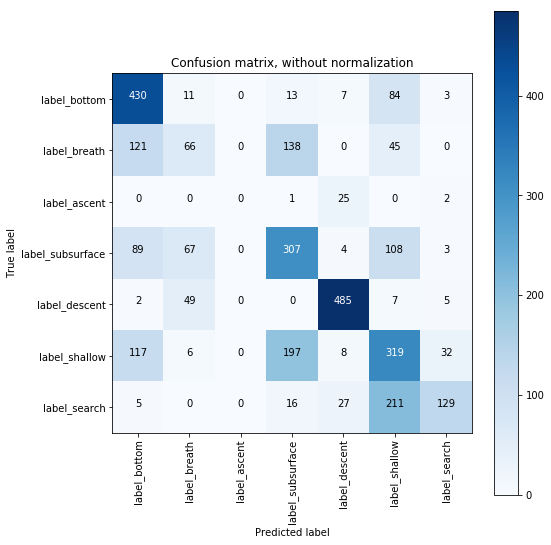

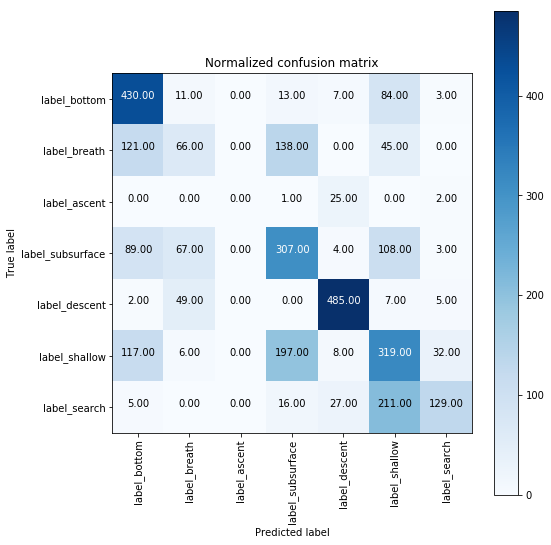

2019-01-20 08:20:27,025 [MainThread  ] [ERROR]  Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3

In [ ]:
###################
### Run experiments
###################

for row in experiments.values:
    
    # get experiment params from dataframe row
    experiment = dict(zip(experiments.columns, row))
    print(experiment)

    logging.info("Begin experiment for model_id={}".format(experiment['model_id']))
    
    architecture = Architecture(model_id = experiment['model_id'], 
                                architecture = experiment['architecture'], 
                                sequence_length = experiment['sequence_length'], 
                                pretrained_model_name = experiment['pretrained_model_name'],
                                pooling = experiment['pooling'],
                                sequence_model = experiment['sequence_model'],
                                sequence_model_layers = experiment['sequence_model_layers'],
                                layer_1_size = experiment['layer_1_size'],
                                layer_2_size = experiment['layer_2_size'],
                                layer_3_size = experiment['layer_3_size'],
                                dropout = experiment['dropout'],
                                verbose=True)
    
    architecture.train_model()

## batch 2

In [ ]:
#######################
### image_MLP_trainable
#######################

architecture = 'video_LRCNN_trainable'

In [ ]:
#########################
### video_LRCNN_trainable
#########################

architecture = 'video_LRCNN_trainable'

## batch 3

In [ ]:
# TODO - custom weights MLP loaded into trainable and LRCNN

## batch 4

In [ ]:
#######
### C3D
#######

architecture = 'C3D'

############
### C3Dsmall
############

architecture = 'C3Dsmall' 

# Run experiments

In [ ]:
# architecture = Architecture(model_id = 1221, 
#                             architecture = 'image_MLP_trainable',
#                             sequence_length = 1, 
#                             pretrained_model_name = "vgg16", 
#                             pooling = 'max', 
#                             layer_1_size=32,
#                             layer_2_size=0, 
#                             layer_3_size=0,
#                             dropout=0.2,
#                             verbose=True)

In [ ]:
architecture = Architecture(model_id = 55, 
                            architecture = 'image_MLP_frozen',
                            sequence_length = 1, 
                            pretrained_model_name = "vgg16", 
                            pooling = 'max', 
                            layer_1_size=256,
                            layer_2_size=128, 
                            layer_3_size=0,
                            dropout=0.2,
                            verbose=True)

In [ ]:
architecture.train_model()

# Debug

## image_MLP_trainable

In [ ]:
pretrained_model_name = "vgg16"
pooling="max"
sequence_length = 2

layer_1_size = 128
layer_2_size = 64
layer_3_size = 32
dropout=0.20

data = Data(sequence_length = 1, 
            return_CNN_features = False, 
            pretrained_model_name=pretrained_modesl_name,
            pooling = pooling,
            return_generator=True,
            batch_size=32)

num_classes = data.num_classes 
frame_size = data.frame_size
num_features = pretrained_model_len_features[pretrained_model_name]

In [ ]:
architecture = Architecture(model_id = 1, 
                            architecture = 'image_MLP_trainable',
                            sequence_length = 1, 
                            num_classes = num_classes, 
                            pretrained_model_name = pretrained_model_name, 
                            pooling = 'max', 
                            layer_1_size=128,
                            layer_2_size=0, 
                            layer_3_size=0,
                            dropout=0.2)

In [ ]:
fit(model_id=1337, model = architecture.model, data = data)

## image_MLP_frozen

In [ ]:
pretrained_model_name = "vgg16"
pooling="max"
layer_1_size = 128
layer_2_size = 64
layer_3_size = 32
dropout=0.20

In [ ]:
data = Data(sequence_length = 1, 
            return_CNN_features = True, 
            pretrained_model_name=pretrained_model_name,
            pooling = pooling)

In [ ]:
num_classes = data.num_classes 
frame_size = data.frame_size
num_features = pretrained_model_len_features[pretrained_model_name]

In [ ]:
architecture = Architecture(model_id = 1, 
                            architecture = 'image_MLP_frozen',
                            sequence_length = 1, 
                            num_classes = num_classes, 
                            pretrained_model_name = pretrained_model_name, 
                            pooling = 'max', 
                            layer_1_size=128,
                            layer_2_size=0, 
                            layer_3_size=0,
                            dropout=0.2)

In [ ]:
# train model
fit_history = fit(model_id = 1, model = architecture.model, data = data, learning_rate = 0.001, epochs = 10)

## video_MLP_concat

In [ ]:
pretrained_model_name = "vgg16"
pooling="max"
sequence_length = 3
layer_1_size = 128
layer_2_size = 64
layer_3_size = 32
dropout=0.20

In [ ]:
data = Data(sequence_length = sequence_length, 
            return_CNN_features = True, 
            pretrained_model_name=pretrained_model_name,
            pooling = pooling)

In [ ]:
num_classes = data.num_classes 
frame_size = data.frame_size
num_features = pretrained_model_len_features[pretrained_model_name]

In [ ]:
architecture = Architecture(model_id = 1, 
                            architecture = 'video_MLP_concat',
                            sequence_length = 3, 
                            num_classes = num_classes, 
                            pretrained_model_name = pretrained_model_name, 
                            pooling = 'max', 
                            layer_1_size=128,
                            layer_2_size=0, 
                            layer_3_size=0,
                            dropout=0.2)

In [ ]:
# train model
fit_history = fit(model_id = 1, model = architecture.model, data = data, learning_rate = 0.001, epochs = 10)

## video_LRCNN_frozen

In [ ]:
pretrained_model_name = "vgg16"
pooling="max"
sequence_length = 
layer_1_size = 128
layer_2_size = 64
layer_3_size = 32
dropout=0.20

In [ ]:
data = Data(sequence_length = sequence_length, 
            return_CNN_features = True, 
            pretrained_model_name=pretrained_model_name,
            pooling = pooling)

In [ ]:
architecture = Architecture(model_id=1,
                            architecture="video_LRCNN_frozen", 
                            sequence_model = 'LSTM',
                            sequence_model_layers = 1,
                            sequence_length = sequence_length,
                            num_classes = data.num_classes, 
                            frame_size = data.frame_size, 
                            pretrained_model_name='vgg16', 
                            pooling='max',
                            layer_1_size=64, 
                            layer_2_size=32, 
                            layer_3_size=8, 
                            dropout=0.2,
                            convolution_kernel_size=3)

In [ ]:
# train model
fit_history = fit(model_id=1, model=architecture.model, data=data, learning_rate = 0.001, epochs = 50)

## video_LRCNN_trainable

In [ ]:
sequence_length=5

In [ ]:
data = Data(sequence_length = sequence_length, 
            return_CNN_features = False, 
            pretrained_model_name="vgg16",
            pooling = "max",
            batch_size=32,
            return_generator=True)

In [ ]:
architecture = Architecture(model_id = 4,
                            architecture="video_LRCNN_trainable", 
                            sequence_model = 'LSTM',
                            sequence_model_layers = 1,
                            sequence_length = sequence_length,
                            num_classes = data.num_classes, 
                            frame_size = data.frame_size, 
                            pretrained_model_name='vgg16', 
                            pooling='max',
                            layer_1_size=64, 
                            layer_2_size=32, 
                            layer_3_size=8, 
                            dropout=0.2,
                            convolution_kernel_size=3)

In [ ]:
# train model
fit_history = fit(model_id = 1, model = architecture.model, data = data, learning_rate = 0.001, epochs = 50)

## C3D

In [ ]:
architecture = Architecture(model_id = 4,
                            architecture="C3D", 
                            sequence_length = 16,
                            num_classes = data.num_classes, 
                            frame_size = data.frame_size)

In [ ]:
# train model
fit_history = fit(model_id = 122, model = architecture.model, data = data, learning_rate = 0.001, epochs = 10)

## C3Dsmall

In [ ]:
data = Data(sequence_length = 16, 
            return_CNN_features = False, 
            frame_size = (112,112),
            return_generator=True,
            batch_size=32,
            verbose=False)

In [ ]:
architecture = Architecture(model_id = 4,
                            architecture="C3Dsmall", 
                            sequence_length = 16,
                            num_classes = data.num_classes, 
                            frame_size = data.frame_size)

In [ ]:
# train model
fit_history = fit(model_id = 122, model = model, data = data, learning_rate = 0.001, epochs = 10)

# analyze results

In [ ]:
path_models = pwd + 'models/'

results = []

for folder, subs, files in os.walk(path_models):
    for filename in files:
        if 'results.json' in filename:
            with open(os.path.abspath(os.path.join(folder, filename))) as f:
                data = json.load(f)
            results.append(data)

results = pd.DataFrame(results)        
results.sort_values("fit_val_acc", inplace=True, ascending=False)

In [ ]:
results.head(10)